In [1]:
from subprocess import Popen, PIPE
import getpass
username='EZAGAYNAYA'
REALM='BEE.VIMPELCOM.RU'
password = getpass.getpass(prompt='Enter Your Ldap password:\n')
kinit = 'kinit'
kinit_args = [ kinit, '%s@%s' % (username, REALM) ]
kinit = Popen(kinit_args, stdin=PIPE, stdout=PIPE, stderr=PIPE)
kinit.stdin.write(bytearray(password + "\n", "ascii"))
kinit.stdin.flush()
kinit.wait()

Enter Your Ldap password:
 ········


0

In [2]:
from pyspark import SparkConf  # noqa: E402
from pyspark.sql import DataFrame as SparkDataFrame  # noqa: E402
from pyspark.sql import SparkSession  # noqa: E402
from pyspark.sql import functions as F  # noqa: E402
from pyspark.sql.functions import col, when, min, max, sum, mean, count, substring, countDistinct, last_day, concat_ws 
from pyspark.sql.types import StringType, LongType

SPARK_SETTINGS = [
    ('spark.yarn.queue', 'default'),
        ('spark.sql.sources.partitionOverwriteMode', 'dynamic'),
        ('hive.exec.dynamic.partition', 'true'),
        ('hive.exec.dynamic.partition.mode', 'nonstrict'),
        ('spark.default.parallelism', '400'),
        ('spark.driver.memory', '20G'),
        ('spark.driver.memoryOverhead', '2G'),
        ('spark.driver.cores', 4),
        ('spark.driver.maxResultSize', '150G'),
        ('spark.dynamicAllocation.enabled', 'false'),
        ('spark.dynamicAllocation.maxExecutors', 200),
        ('spark.executor.memory', '20G'),
        ('spark.executor.memoryOverhead', '4G'),
        ('spark.executor.cores', 6),
        ('spark.executor.instances', 10),
        ('spark.hadoop.mapreduce.input.fileinputformat.input.dir.recursive', 'true'),
        ('spark.hive.mapred.supports.subdirectories', 'true'),# драйвер (понадобится для чтения из RDBMS)
        ('spark.kryoserializer.buffer', '1000m'),
        ('spark.kryoserializer.buffer.max', '2000m'),
        ('spark.rpc.message.maxSize', 2000),
        ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
        ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
        ('spark.sql.shuffle.partitions', '400'),
        ('spark.driver.extraClassPath', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'), # драйвер (понадобится для чтения из RDBMS)
        ('spark.jars', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'),
        ("spark.sql.hive.convertMetastoreOrc", " false"),
        ('spark.app.name', 'SVFomenkov_testing_pipeline')
]

app_name = 'ZEM_spark_session'

conf = SparkConf().setAppName(app_name).setMaster('yarn').setAll(SPARK_SETTINGS)
spark = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel('ERROR')
spark.conf.set("spark.sql.hive.convertMetastoreOrc", " false")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/15 15:46:08 WARN HiveConf: HiveConf of name hive.mapred.supports.subdirectories does not exist
25/09/15 15:46:10 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
from IPython.display import display, HTML
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

/tmp/ipykernel_2648/3383840084.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### df Spark

In [4]:
# # Данные обучения предыдущей модели:
# # df_spark = spark.read.table('b2b_cltv_stg.vpg_ml_potential_models_train_oct24_v2_temp_delete')

# # b2b_cltv_stg.cvm_box_ml_features_v1 - выручка

# df_prod_rev = spark.read.table('b2b_cltv_stg.cvm_box_ml_features_v1')

# print('num_rows:', df_prod_rev.count())  
# print('num_cols:', len(df_prod_rev.columns))  
# df_prod_rev.show(5)

# # num_rows: 108 642
# # num_cols: 6

In [5]:
# df_prod_rev_pd = df_prod_rev.toPandas()

# print(df_prod_rev_pd.shape)
# df_prod_rev_pd.head(2)

# # (108 642, 6)

#### to Pandas

In [4]:
import pandas as pd
import numpy as np
import scipy as sp

import pickle
# import shap

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, datasets, linear_model, metrics

import seaborn as sns

import datetime as dt
from datetime import datetime
from datetime import date
import math

# TF-IDF:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mean', 'sum', 'max', 'datetime', 'min']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#### b2b_cltv_stg.cvm_box_ml_features_v1

In [7]:
# df.to_pickle('df_products.pkl')
df_prod_rev_pd = pd.read_pickle('df_products.pkl')

print(df_prod_rev_pd.shape)
df_prod_rev_pd.head(2)

# (108 642, 6)

(108642, 6)


,client_inn,revenue,traf_internet_amt,traf_voice_amt,product_name,calendar_dt
0,5906996069,99905.3900,None,None,m2m_cup,2025-03-01
1,1513059178,8326.7400,None,None,m2m_cup,2025-03-01


<Figure size 2000x4000 with 0 Axes>

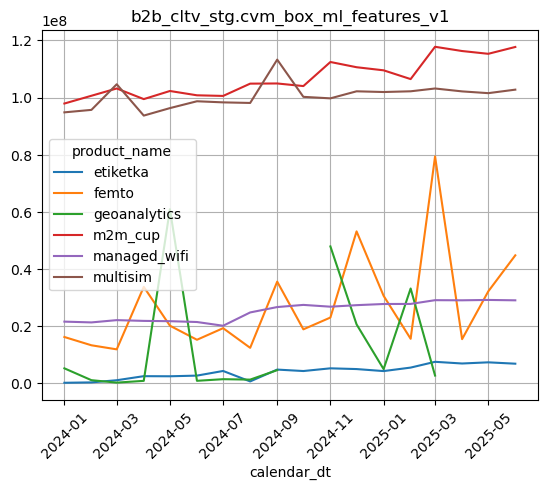

In [151]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(20, 40)

df_agg = df_prod_rev_pd.groupby(['calendar_dt', 'product_name'])['revenue'].sum().astype(int).unstack().plot()
plt.title("b2b_cltv_stg.cvm_box_ml_features_v1")
plt.xticks(rotation = 45)
plt.grid()

In [152]:
df_prod_rev_pd['product_name'].value_counts()

m2m_cup         40796
multisim        26906
managed_wifi    19869
etiketka        11725
femto            9307
geoanalytics       39
Name: product_name, dtype: int64

In [ ]:
df_prod_rev_pd['calendar_dt'].value_counts()

In [ ]:
df_prod_rev_pd[df_prod_rev_pd['product_name'] == 'm2m_cup'][['client_inn', 'calendar_dt']].groupby('client_inn')['calendar_dt'].count()

In [ ]:
df_prod_rev_pd['client_inn'].nunique()

In [ ]:
df_prod_rev_pd[df_prod_rev_pd['product_name'] == 'm2m_cup']['client_inn'].nunique()

In [ ]:
# 2628 / 108642

#### Aggregation

In [ ]:
print(df_prod_rev_pd.shape)
df_prod_rev_pd.head(3)

In [ ]:
df_prod_rev_pd.groupby(['client_inn', 'product_name'])[['revenue', 'traf_internet_amt', 'traf_voice_amt', 'calendar_dt']] \
        .agg({'revenue': 'sum', 'traf_internet_amt': 'sum', 'traf_voice_amt': 'sum', 'calendar_dt': 'min'})

#### df_agg_prod

In [ ]:
df_agg_prod = df_prod_rev_pd.groupby(['client_inn', 'product_name'])[['revenue', 'traf_internet_amt', 'traf_voice_amt', 'calendar_dt']] \
        .agg({'revenue': 'sum', 'traf_internet_amt': 'sum', 'traf_voice_amt': 'sum', 'calendar_dt': 'min'}).reset_index()

print(df_agg_prod.shape)
df_agg_prod.head()

In [ ]:
df_prod_rev_pd['m2m_flag'] = df_prod_rev_pd['product_name'].apply(lambda x: 1 if x == 'm2m_cup' else 0)

df_prod_rev_pd['m2m_flag'].value_counts()

In [ ]:
print(df_prod_rev_pd.shape)
df_prod_rev_pd

In [ ]:
df_prod_rev_pd['calendar_dt'].value_counts()

In [ ]:
print(df_prod_rev_pd.shape)

df_agg_prod_1 = df_prod_rev_pd.groupby(['client_inn', 'product_name', 'calendar_dt'])[['revenue', 'traf_internet_amt', 'traf_voice_amt', 'calendar_dt']] \
        .agg({'revenue': 'sum', 'traf_internet_amt': 'sum', 'traf_voice_amt': 'sum'}).reset_index()

print(df_agg_prod_1.shape)
df_agg_prod_1.head()

In [ ]:
df_prod_rev_pd['m2m_flag'] = df_prod_rev_pd['product_name'].apply(lambda x: 1 if x == 'm2m_cup' else 0)
df_prod_rev_pd['m2m_flag'].value_counts()

In [ ]:
df_prod_rev_pd.head()

In [ ]:
df_agg_prod_1['calendar_dt_lagged'] = df_agg_prod_1.groupby(['client_inn', 'product_name'])['calendar_dt'].shift(1)
df_agg_prod_1

#### Таблицы контур фокус

ОКВЭД

In [ ]:
# spark.read.table("b2bs_dm.kontur_focus_okvades").show(5)

#### Финансовая отчётность для ИНН

In [ ]:
df_fin_report = spark.read.table("b2bs_dm.kontur_focus_buh_data")

df_fin_report.show(5)

In [ ]:
df_fin_report_pd = df_fin_report.toPandas()

print(df_fin_report_pd.shape)
df_fin_report_pd.head(3)

In [ ]:
print(df_fin_report_pd.shape)
df_fin_report_pd.head(3)

In [ ]:
# spark.read.table("b2bba_prod.fa_report_detail_new").show(5)

#### Таблица от ba с выручкой по продуктам и группам продуктов

Можно использовать для сбора базы ИНН

In [ ]:
# fa_revenue = (
#     spark.read.table("b2bba_prod.fa_report_detail_new")
#     .groupBy("dt", "revenue_type")
#     .agg(F.sum(F.col("revenue")).alias("revenue"))
# ).toPandas()

In [ ]:
# # пример сбора базы ИНН на определенный месяц
# spark.read.table("b2bba_prod.fa_report_detail_new").filter(F.col("dt") == "2025-03-01").select("inn").dropDuplicates().count()

In [ ]:
# ********************************************************************************************************************************

#### b2b_profile.cvm_box_customer

In [ ]:
df_cvm_box = spark.read.table('b2b_profile.cvm_box_customer')

print('num_rows:', df_cvm_box.count())  
print('num_cols:', len(df_cvm_box.columns))  
df_cvm_box.show(5)

# num_rows: 302402
# num_cols: 12

In [ ]:
# df_cvm_box.select('update_date').dropDuplicates().show()

# 2025-08-13

In [ ]:
df_cvm_box_pd = df_cvm_box.toPandas()

print(df_cvm_box_pd.shape)
df_cvm_box_pd.head()

In [ ]:
df_cvm_box_pd.drop('acrm_objid', axis = 1, inplace = True)

print(df_cvm_box_pd.shape)
df_cvm_box_pd.head(2)

In [ ]:
df_cvm_box_pd['type'].value_counts()

In [ ]:
df_cvm_box_pd['cust_segment_key'].value_counts()

In [ ]:
df_cvm_box_pd['site_objid'].value_counts()

In [ ]:
df_cvm_box_pd['first_ban_create_date'].value_counts()

In [ ]:
df_cvm_box_pd.info()

In [ ]:
df_cvm_box_pd.nunique()

In [ ]:
print(df_cvm_box_pd.shape)

df_cvm_box_pd.drop(['state', 'update_date'], axis = 1, inplace = True)

print(df_cvm_box_pd.shape)

In [ ]:
df_cvm_box_pd.head(2)

In [ ]:
# df_cvm_box_pd.to_pickle('df_cvm_box_pd.pkl')
# df_cvm_box_pd = pd.read_pickle('df_cvm_box_pd.pkl')

print(df_cvm_box_pd.shape)
df_cvm_box_pd.head(2)

# (302402, 9)

#### join inn with flags

In [ ]:
print(df_prod_rev_pd.shape)
df_prod_rev_pd.head(2)

In [ ]:
df_prod_rev_pd['product_name'].value_counts()

In [ ]:
df_agg_prod = df_prod_rev_pd.groupby(['client_inn', 'product_name'])[['revenue', 'traf_internet_amt', 'traf_voice_amt', 'calendar_dt']] \
        .agg({'revenue': 'sum', 'traf_internet_amt': 'sum', 'traf_voice_amt': 'sum', 'calendar_dt': 'min'}).reset_index()

# 8611
print(df_agg_prod.shape)
df_agg_prod.head()

In [ ]:
df_agg_prod['client_inn'].nunique()

In [ ]:
df_agg_prod['calendar_dt'].max()

In [ ]:
df_agg_prod['client_inn'].value_counts()

In [ ]:
df_agg_prod[df_agg_prod['client_inn'] == '7710140679']

In [ ]:
df_agg_prod[df_agg_prod['product_name'] == 'm2m_cup'].shape

In [ ]:
df_agg_prod[df_agg_prod['product_name'] == 'm2m_cup']['client_inn'].nunique()

In [ ]:
df_cvm_box_pd.rename(columns = {'cust_inn': 'client_inn'}, inplace = True)

In [ ]:
df_cvm_box_products = df_cvm_box_pd.merge(df_agg_prod[['client_inn', 'product_name', 'revenue', 
                                                       'traf_internet_amt', 'traf_voice_amt']], how = 'left', on = 'client_inn')

print(df_cvm_box_pd.shape)
print(df_cvm_box_products.shape)
df_cvm_box_products.head(2)

In [ ]:
303042 - 302402

In [ ]:
df_cvm_box_products.drop_duplicates().shape

In [ ]:
df_cvm_box_products.groupby(['client_inn', 'product_name'])['client_inn'].count().unique()

In [ ]:
df_cvm_box_products['product_name'].value_counts()

In [ ]:
df_cvm_box_products['client_inn'].nunique()

In [ ]:
"{:.2%}".format(2367 / 302402)

In [ ]:
# OGRN

df_okvades = spark.read.table("b2bs_dm.kontur_focus_okvades").toPandas()
print(df_okvades.shape)
df_okvades.head(2)

In [64]:
df_okvades['update_date'].value_counts()

2024-08-12    25470511
Name: update_date, dtype: int64

In [65]:
df_okvades['type'].value_counts()

complementaryActivity    23063061
principalActivity         2407450
Name: type, dtype: int64

In [66]:
df_okvades.rename(columns = {'inn': 'client_inn'}, inplace = True)

In [67]:
df_okvades_agg = df_okvades[['client_inn', 'ogrn']].groupby('client_inn').max().reset_index()
df_okvades_agg.head(2)

,client_inn,ogrn
0,0100000491,1210100002782
1,0100000607,1220100000086


In [68]:
df_cvm_prod_ogrn = df_cvm_box_products.merge(df_okvades_agg, how = 'left', on = 'client_inn')

# (302611, 10)
print(df_cvm_prod_ogrn.shape)
df_cvm_prod_ogrn.head(2)

(303042, 14)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,first_ban_create_date,product_name,revenue,traf_internet_amt,traf_voice_amt,ogrn
0,2147484233,1656050085,"Силовая Электротехника, ООО",SH,Юр. лицо,Не определено,KZN,268435584.0000000000,2015-06-26,NaN,NaN,NaN,NaN,1151690042107
1,1597531,7736673181,"Лаймстоун, ООО",SH,Юр. лицо,Обычный,VIP,268435563.0000000000,2019-10-15,NaN,NaN,NaN,NaN,1147746325275


In [69]:
# *** Фин отчетность для ИНН: ***

print(df_fin_report_pd.shape)
df_fin_report_pd.head(2)

(136140325, 8)


,inn,year,code,name_param,start_value,end_value,organization_type,form
0,3906070115,2012,1100,Итого,49356000.0,59464000.0,Large,form1
1,3906070115,2012,1110,Нематериальные активы,0.0,0.0,Large,form1


In [70]:
df_fin_report_pd['organization_type'].value_counts()

Large    102913274
Small     32867335
SONO        359716
Name: organization_type, dtype: int64

In [71]:
df_fin_report_pd['form'].value_counts()

form1    88109886
form2    48030439
Name: form, dtype: int64

In [72]:
df_fin_report_pd.rename(columns = {'inn': 'client_inn'}, inplace = True)

In [73]:
df_fin_report_pd['client_inn'].nunique()

535820

In [74]:
# df_fin_report_pd[['client_inn', 'organization_type', 'form', 'start_value', 'end_value']].groupby(['client_inn', 'organization_type', 'form']) \
#                                 [['start_value', 'end_value']].sum().reset_index()

df_fin_report_agg =  df_fin_report_pd[['client_inn', 'start_value', 'end_value']].groupby(['client_inn']) \
                                [['start_value', 'end_value']].sum().reset_index()

print(df_fin_report_agg.shape)
df_fin_report_agg.head(3)

# 535 820 

(535820, 3)


,client_inn,start_value,end_value
0,0100000491,1.173570e+10,3.040380e+10
1,0100000607,6.506000e+06,3.122400e+07
2,0100000710,2.809000e+06,2.679600e+07


In [75]:
df_cvm_prod_ogrn_fin = df_cvm_prod_ogrn.merge(df_fin_report_agg, how = 'left', on = 'client_inn')

print(df_cvm_prod_ogrn_fin.shape)
df_cvm_prod_ogrn_fin.head(2)

(303042, 16)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,first_ban_create_date,product_name,revenue,traf_internet_amt,traf_voice_amt,ogrn,start_value,end_value
0,2147484233,1656050085,"Силовая Электротехника, ООО",SH,Юр. лицо,Не определено,KZN,268435584.0000000000,2015-06-26,NaN,NaN,NaN,NaN,1151690042107,2.257570e+09,2.742392e+09
1,1597531,7736673181,"Лаймстоун, ООО",SH,Юр. лицо,Обычный,VIP,268435563.0000000000,2019-10-15,NaN,NaN,NaN,NaN,1147746325275,9.399210e+08,1.022296e+09


In [76]:
df_cvm_prod_ogrn_fin['start_value'].isna().sum()

116321

In [77]:
# ****************************************************************************************************************************************

#### b2bba_dm.fa_revenue_detail

In [89]:
df_revenue_detail = spark.read.table("b2bba_dm.fa_revenue_detail")

print(df_revenue_detail.count())
df_revenue_detail.show(5)

19534716
+-------------------+-----------+------------+----------+--------------------+---------------+-----------------+------+---+-----------------+-------+----------+----------+-------+--------+-------------+----------+-------+--------+--------------------+-----------------+----------+------------+---------+------+--------+-------------------+--------------------+
|                 dt|contract_no|         inn| client_id|         client_name|client_group_id|client_group_name|region|mkt|           market|segment|subsegment|flag_agent|flag_mk|flag_gos|flag_national|flag_alloc|flag_sp|flag_otm|               sales|         sales_tn|sales_func|revenue_type|  account|domain| revenue|        source_name|           load_date|
+-------------------+-----------+------------+----------+--------------------+---------------+-----------------+------+---+-----------------+-------+----------+----------+-------+--------+-------------+----------+-------+--------+--------------------+-----------------+

In [90]:
df_revenue_detail_pd = df_revenue_detail.toPandas()

df_revenue_detail_pd['load_date'].value_counts()

2025-07-24 00:22:28.611    19534716
Name: load_date, dtype: int64

In [91]:
df_revenue_detail_pd['dt'].sort_values().value_counts()

2024-01-01    1126797
2024-02-01    1115640
2024-03-01    1103826
2024-04-01    1101497
2024-05-01    1085150
2024-07-01    1085112
2024-08-01    1084706
2025-04-01    1083630
2024-06-01    1082618
2024-10-01    1081948
2024-12-01    1079490
2024-09-01    1079472
2025-03-01    1074142
2024-11-01    1072947
2025-06-01    1072483
2025-05-01    1072268
2025-01-01    1068454
2025-02-01    1064536
Name: dt, dtype: int64

In [92]:
df_revenue_detail_pd[df_revenue_detail_pd['dt'] == '2025-06-01']['inn'].nunique()

233090

In [94]:
dt_rev_max = df_revenue_detail_pd['dt'].max()
dt_rev_max

Timestamp('2025-06-01 00:00:00')

In [102]:
df_revenue_detail_dt = df_revenue_detail_pd[df_revenue_detail_pd['dt'] == dt_rev_max]

print(df_revenue_detail_dt.shape)
df_revenue_detail_dt.head(2)

(1072483, 28)


,dt,contract_no,inn,client_id,client_name,client_group_id,client_group_name,region,mkt,market,...,flag_otm,sales,sales_tn,sales_func,revenue_type,account,domain,revenue,source_name,load_date
2570336,2025-06-01,000135,9909068806,925096,"ХОККАЙДО СИМБУН, АО ИЗДАТЕЛЬСТВО",None,None,Москва,VIP,Москва,...,0,Новиков Сергей Алексеевич,237334,Sales SE Farmer,fix_voice,Voice,SB VAS,1658.39,fix_revenue_monthly,2025-07-24 00:22:28.611
2570337,2025-06-01,001203-001,7703373150,646415,"Резник, Гагарин и Партнеры, АБ",None,None,Москва,VIP,Москва,...,0,Скуратович Ольга Николаевна,69773,Sales ME,fix_other,Fix Other,Other,67.23,fix_revenue_monthly,2025-07-24 00:22:28.611


In [103]:
df_revenue_inn_dt = df_revenue_detail_dt['inn'].unique()
print(df_revenue_inn_dt.shape)
df_revenue_inn_dt

(233091,)


array(['9909068806', '7703373150', '9909066580', ..., '3444179933',
       '6164237151', '2367023292'], dtype=object)

In [96]:
print(df_cvm_prod_ogrn_fin.shape)
df_cvm_prod_ogrn_fin.head(2)

(303042, 16)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,first_ban_create_date,product_name,revenue,traf_internet_amt,traf_voice_amt,ogrn,start_value,end_value
0,2147484233,1656050085,"Силовая Электротехника, ООО",SH,Юр. лицо,Не определено,KZN,268435584.0000000000,2015-06-26,NaN,NaN,NaN,NaN,1151690042107,2.257570e+09,2.742392e+09
1,1597531,7736673181,"Лаймстоун, ООО",SH,Юр. лицо,Обычный,VIP,268435563.0000000000,2019-10-15,NaN,NaN,NaN,NaN,1147746325275,9.399210e+08,1.022296e+09


In [97]:
df_inn_cvm_box = df_cvm_prod_ogrn_fin['client_inn'].unique()
print(df_inn_cvm_box.shape)
df_inn_cvm_box

(302402,)


array(['1656050085', '7736673181', '0266045627', ..., '5406616015',
       '5047044531', '3109003990'], dtype=object)

In [98]:
len(set(df_inn_cvm_box).intersection(set(df_revenue_inn_dt)))

214988

In [99]:
len(set(df_revenue_inn_dt).intersection(set(df_inn_cvm_box)))

214988

In [100]:
print(df_cvm_prod_ogrn_fin.shape)
df_cvm_prod_ogrn_fin.head(2)

(303042, 16)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,first_ban_create_date,product_name,revenue,traf_internet_amt,traf_voice_amt,ogrn,start_value,end_value
0,2147484233,1656050085,"Силовая Электротехника, ООО",SH,Юр. лицо,Не определено,KZN,268435584.0000000000,2015-06-26,NaN,NaN,NaN,NaN,1151690042107,2.257570e+09,2.742392e+09
1,1597531,7736673181,"Лаймстоун, ООО",SH,Юр. лицо,Обычный,VIP,268435563.0000000000,2019-10-15,NaN,NaN,NaN,NaN,1147746325275,9.399210e+08,1.022296e+09


In [106]:
print(df_revenue_detail_dt.shape)
df_revenue_detail_dt.iloc[:2, :14]

(1072483, 28)


,dt,contract_no,inn,client_id,client_name,client_group_id,client_group_name,region,mkt,market,segment,subsegment,flag_agent,flag_mk
2570336,2025-06-01,000135,9909068806,925096,"ХОККАЙДО СИМБУН, АО ИЗДАТЕЛЬСТВО",None,None,Москва,VIP,Москва,SME,SH,0,0
2570337,2025-06-01,001203-001,7703373150,646415,"Резник, Гагарин и Партнеры, АБ",None,None,Москва,VIP,Москва,SME,ME,0,0


In [107]:
print(df_revenue_detail_dt.shape)
df_revenue_detail_dt.iloc[:2, 14:]

(1072483, 28)


,flag_gos,flag_national,flag_alloc,flag_sp,flag_otm,sales,sales_tn,sales_func,revenue_type,account,domain,revenue,source_name,load_date
2570336,0.0,None,0,0,0,Новиков Сергей Алексеевич,237334,Sales SE Farmer,fix_voice,Voice,SB VAS,1658.39,fix_revenue_monthly,2025-07-24 00:22:28.611
2570337,0.0,None,0,0,0,Скуратович Ольга Николаевна,69773,Sales ME,fix_other,Fix Other,Other,67.23,fix_revenue_monthly,2025-07-24 00:22:28.611


In [108]:
df_revenue_detail_dt['inn'].vxalue_counts()

6671460670      5634
7744000912      4630
7728029110      4149
7707548740      3833
2310031475      3379
                ... 
720202111675       1
3460080226         1
560900614887       1
0105082522         1
2367023292         1
Name: inn, Length: 233090, dtype: int64

In [149]:
df_revenue_detail_dt['revenue_type'].value_counts()

mobile_vdm               353664
mobile_ic                309890
mobile_roaming            73593
fix_other                 58118
fix_internet              51613
                          ...  
mobile_bank_antifraud         2
fix_equipment_vsaas           1
bigdata_geo                   1
fix_iaas_ot                   1
mobile_corr_sms               1
Name: revenue_type, Length: 67, dtype: int64

In [109]:
df_revenue_detail_dt[df_revenue_detail_dt['inn'] == '6671460670']

,dt,contract_no,inn,client_id,client_name,client_group_id,client_group_name,region,mkt,market,...,flag_otm,sales,sales_tn,sales_func,revenue_type,account,domain,revenue,source_name,load_date
12156397,2025-06-01,835753405,6671460670,3878700,Центр корпоративных подключений,2149725598,ИнвестСтрой,Центр,EKT,Екатеринбургский ф-л,...,0,Гильмаев Тимур Владиславович,343477,Manager Partners,mobile_vdm,Voice+Data+Messaging,Core,122.78,mobile_revenue_monthly,2025-07-24 00:22:28.611
12156398,2025-06-01,835753645,6671460670,3878700,Центр корпоративных подключений,2149725598,ИнвестСтрой,Центр,TUM,Тюменский ф-л,...,0,Гильмаев Тимур Владиславович,343477,Manager Partners,mobile_vdm,Voice+Data+Messaging,Core,276.66,mobile_revenue_monthly,2025-07-24 00:22:28.611
12156399,2025-06-01,835754547,6671460670,3878700,Центр корпоративных подключений,2149725598,ИнвестСтрой,Центр,EKT,Екатеринбургский ф-л,...,0,Гильмаев Тимур Владиславович,343477,Manager Partners,mobile_vdm,Voice+Data+Messaging,Core,686.40,mobile_revenue_monthly,2025-07-24 00:22:28.611
12156400,2025-06-01,835755064,6671460670,3878700,Центр корпоративных подключений,2149725598,ИнвестСтрой,Центр,IGK,Ижевский ф-л,...,0,Гильмаев Тимур Владиславович,343477,Manager Partners,mobile_vdm,Voice+Data+Messaging,Core,333.34,mobile_revenue_monthly,2025-07-24 00:22:28.611
12156402,2025-06-01,835755673,6671460670,3878700,Центр корпоративных подключений,2149725598,ИнвестСтрой,Центр,EKT,Екатеринбургский ф-л,...,0,Гильмаев Тимур Владиславович,343477,Manager Partners,mobile_vdm,Voice+Data+Messaging,Core,312.59,mobile_revenue_monthly,2025-07-24 00:22:28.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19449530,2025-06-01,851693302,6671460670,3878700,Центр корпоративных подключений,2149725598,ИнвестСтрой,Юг,KRD,Краснодарский ф-л,...,0,Клементьев Александр Сергеевич,None,None,mobile_ic,IC,Core,32.00,interconnect,2025-07-24 00:22:28.611
19449531,2025-06-01,851694426,6671460670,3878700,Центр корпоративных подключений,2149725598,ИнвестСтрой,Юг,VLG,Волгоградский ф-л,...,0,Клементьев Александр Сергеевич,None,None,mobile_ic,IC,Core,1.00,interconnect,2025-07-24 00:22:28.611
19449532,2025-06-01,851695274,6671460670,3878700,Центр корпоративных подключений,2149725598,ИнвестСтрой,Юг,KRD,Краснодарский ф-л,...,0,Клементьев Александр Сергеевич,None,None,mobile_ic,IC,Core,63.00,interconnect,2025-07-24 00:22:28.611
19449533,2025-06-01,851695365,6671460670,3878700,Центр корпоративных подключений,2149725598,ИнвестСтрой,Юг,KRD,Краснодарский ф-л,...,0,Клементьев Александр Сергеевич,None,None,mobile_ic,IC,Core,25.00,interconnect,2025-07-24 00:22:28.611


In [125]:
df_revenue_dt_rev_AGG = df_revenue_detail_dt.groupby(['inn', 'region', 'mkt', 'market', 'subsegment', 'flag_agent', 'flag_mk', 'flag_gos', 'flag_national',
'flag_alloc', 'flag_sp', 'flag_otm', 'sales_func', 'revenue_type', 'account', 'domain', 'source_name'])[['revenue']].sum().reset_index()

print(df_revenue_dt_rev_AGG.shape)
df_revenue_dt_rev_AGG.head(2)

(82771, 18)


,inn,region,mkt,market,subsegment,flag_agent,flag_mk,flag_gos,flag_national,flag_alloc,flag_sp,flag_otm,sales_func,revenue_type,account,domain,source_name,revenue
0,0105059227,Юг,KRD,Краснодарский ф-л,LA,0,0,0.0,National,0,0,0,Sales LA,mobile_ic,IC,Core,interconnect,404.00
1,0105059227,Юг,KRD,Краснодарский ф-л,LA,0,0,0.0,National,0,0,0,Sales LA,mobile_roaming,Roaming,Core,mobile_revenue_monthly,120.17


In [137]:
df_revenue_dt_rev_AGG['mkt'].value_counts()

VIP    20091
SPB     3760
NSK     2865
EKT     2487
KZN     2216
       ...  
ANR       72
MGD       62
KZL       50
BIR       48
NTG        7
Name: mkt, Length: 85, dtype: int64

In [126]:
df_revenue_dt_rev_AGG['inn'].nunique()

12499

In [131]:
df_revenue_detail_dt['inn'].nunique()

233090

In [141]:
df_revenue_detail_dt['inn'].value_counts()

6671460670      5634
7744000912      4630
7728029110      4149
7707548740      3833
2310031475      3379
                ... 
720202111675       1
3460080226         1
560900614887       1
0105082522         1
2367023292         1
Name: inn, Length: 233090, dtype: int64

In [143]:
# df_revenue_detail_dt[df_revenue_detail_dt['inn'] == '6671460670']

In [147]:
print(df_revenue_detail_dt.shape)
df_revenue_detail_dt = df_revenue_detail_dt[~df_revenue_detail_dt['inn'].isin(['-', '.'])]
print(df_revenue_detail_dt.shape)

(1072483, 28)
(1072473, 28)


In [167]:
df_revenue_detail_dt_INN = df_revenue_detail_dt[['inn', 'revenue']].groupby(['inn'])['revenue'].sum().reset_index()
df_revenue_detail_dt_INN.rename(columns = {'inn': 'client_inn', 'revenue': 'revenue_detail_sum'}, inplace = True)
df_revenue_detail_dt_INN.head(3)

,client_inn,revenue_detail_sum
0,0000000000,404467.04
1,000000000000,62883.06
2,0015300361,277.30


In [168]:
print(df_cvm_prod_ogrn_fin.shape)
df_cvm_prod_ogrn_fin.rename(columns = {'revenue': 'revenue_product'}, inplace = True)

df_cvm_prod_ogrn_fin_rev = df_cvm_prod_ogrn_fin.merge(df_revenue_detail_dt_INN, on = 'client_inn', how = 'left')
print(df_cvm_prod_ogrn_fin_rev.shape)
df_cvm_prod_ogrn_fin_rev.head(3)

(303042, 16)
(303042, 17)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,first_ban_create_date,product_name,revenue_product,traf_internet_amt,traf_voice_amt,ogrn,start_value,end_value,revenue_detail_sum
0,2147484233,1656050085,"Силовая Электротехника, ООО",SH,Юр. лицо,Не определено,KZN,268435584.0000000000,2015-06-26,NaN,NaN,NaN,NaN,1151690042107,2.257570e+09,2.742392e+09,1466.72
1,1597531,7736673181,"Лаймстоун, ООО",SH,Юр. лицо,Обычный,VIP,268435563.0000000000,2019-10-15,NaN,NaN,NaN,NaN,1147746325275,9.399210e+08,1.022296e+09,NaN
2,8117085,0266045627,ОНЕСТ,SE,Юр. лицо,Не определено,UFA,268435585.0000000000,2018-01-18,NaN,NaN,NaN,NaN,1150280068223,6.683915e+09,8.777401e+09,19549.06


In [169]:
df_cvm_prod_ogrn_fin_rev[['revenue_product', 'revenue_detail_sum']]

,revenue_product,revenue_detail_sum
0,NaN,1466.72
1,NaN,NaN
2,NaN,19549.06
3,NaN,277177.56
4,NaN,1932.86
...,...,...
303037,NaN,NaN
303038,NaN,NaN
303039,NaN,5067.61
303040,NaN,NaN


In [170]:
df_cvm_prod_ogrn_fin_rev[~df_cvm_prod_ogrn_fin_rev['revenue_product'].isna()][['revenue_product', 'revenue_detail_sum']]

,revenue_product,revenue_detail_sum
21,432000.0000,110469.35
36,113.0400,15702.58
37,1572752.6900,219325.30
43,240000.0000,325705.28
45,4226.9700,1316.94
...,...,...
302481,63938.1600,11182.28
302560,26414.5800,15529.62
302672,12009.0400,9367.13
302685,23400.0000,2590.72


#### b2b_profile.org_kontur_focus_galaxy

In [187]:
# df_external_2 = spark.read.table('b2b_profile.org_kontur_focus_galaxy')

# df_external_2_pd.to_pickle('df_external_2_pd.pkl')
df_kontur_focus = pd.read_pickle('df_external_2_pd.pkl')

print(df_kontur_focus.shape)
df_kontur_focus.head(2)

# (6 293 630, 47)

(6293630, 47)


,CLIENT_INN,OGRN,LEGAL_NAME,KPP,LEGAL_NAME_SHORT,LEGAL_NAME_FULL,OPF,REGISTRATION_DATE,LEGAL_ADDRESS,REGION_TYPE,...,MSP_IN_DATE,MSP_OUT_DATE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_DATE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR,TIME_KEY
0,0100008758,1240100001580,"ООО ""Омнитех Солюшнс""",010001001,"ООО ""ОМНИТЕХ СОЛЮШНС""","ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ОМНИ...",Общества с ограниченной ответственностью,2024-06-06,"385141, Республика Адыгея (Адыгея), м.р-н Тахт...",республика,...,2024-07-10,None,NaN,None,NaN,NaN,NaN,NaN,NaN,2025-04-02
1,0100009649,1240100002482,Региональная Физкультурно-Спортивная Обществен...,010001001,"РФС ОО ""ФЛБ"" РА",РЕГИОНАЛЬНАЯ ФИЗКУЛЬТУРНО-СПОРТИВНАЯ ОБЩЕСТВЕН...,Общественные организации,2024-08-30,"385019, Республика Адыгея (Адыгея), г.о. Город...",республика,...,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,2025-04-02


In [226]:
df_kontur_focus['TIME_KEY'].value_counts()

2025-04-02    6293630
Name: TIME_KEY, dtype: int64

In [188]:
# data.columns = [x.lower() for x in data.columns]
# data.columns = map(str.lower, data.columns)

# df_kontur_focus.columns = map(str.lower, df_kontur_focus.columns)
df_kontur_focus.rename(columns = {'CLIENT_INN': 'client_inn'}, inplace = True)
# df_kontur_focus.columns

In [189]:
df_kontur_focus['client_inn'].nunique()

6293630

In [190]:
df_kontur_focus.rename(columns = {'revenue': 'revenue_kontur'}, inplace = True)

In [191]:
print(df_cvm_prod_ogrn_fin_rev.shape)
df_cvm_prod_ogrn_fin_rev.drop('ogrn', axis = 1, inplace = True)
df_cvm_prod_ogrn_fin_rev_focus = df_cvm_prod_ogrn_fin_rev.merge(df_kontur_focus, how = 'left', on = 'client_inn')
print(df_cvm_prod_ogrn_fin_rev_focus.shape)

(303042, 17)
(303042, 62)


In [194]:
17 + 45

62

In [195]:
df_cvm_prod_ogrn_fin_rev_focus.head(2)

,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,first_ban_create_date,product_name,...,MSP_IN_DATE,MSP_OUT_DATE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_DATE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR,TIME_KEY
0,2147484233,1656050085,"Силовая Электротехника, ООО",SH,Юр. лицо,Не определено,KZN,268435584.0000000000,2015-06-26,NaN,...,2016-08-01,None,4.0,2023-12-31,2023.0,22575000.0,2024.0,29000.0,2024.0,2025-04-02
1,1597531,7736673181,"Лаймстоун, ООО",SH,Юр. лицо,Обычный,VIP,268435563.0000000000,2019-10-15,NaN,...,2016-08-01,None,14.0,2023-12-31,2023.0,26265000.0,2023.0,258000.0,2023.0,2025-04-02


In [196]:
df_cvm_prod_ogrn_fin_rev_focus.columns

Index(['cust_id', 'client_inn', 'cust_name', 'cust_segment_key', 'type',
       'characterization', 'hq_market', 'site_objid', 'first_ban_create_date',
       'product_name', 'revenue_product', 'traf_internet_amt',
       'traf_voice_amt', 'start_value', 'end_value', 'revenue_detail_sum',
       'OGRN', 'LEGAL_NAME', 'KPP', 'LEGAL_NAME_SHORT', 'LEGAL_NAME_FULL',
       'OPF', 'REGISTRATION_DATE', 'LEGAL_ADDRESS', 'REGION_TYPE',
       'REGION_NAME', 'REGION_CODE', 'STATUS', 'BANKRUPTING', 'DISSOLVED',
       'DISSOLVING', 'REORGANIZING', 'STATUS_DATE', 'OKATO', 'OKFS', 'OKOGU',
       'OKOPF', 'OKPO', 'OKTMO', 'DISSOLUTION_DATE', 'AGE', 'HEADS',
       'PRIVACY_FORM', 'OKVED_CODE', 'OKVED_TEXT', 'OKVED_CLASS_CODE',
       'OKVED_CLASS_NAME', 'OKVED_CHAPTER_CODE', 'OKVED_CHAPTER_NAME',
       'INDUSTRY_GROUP', 'STATEDCAPITAL', 'MSP_TYPE', 'MSP_IN_DATE',
       'MSP_OUT_DATE', 'COUNT_EMPLOYEE', 'COUNT_EMPLOYEE_DATE',
       'COUNT_EMPLOYEE_YEAR', 'REVENUE', 'REVENUE_YEAR', 'NET_PROFIT',


#### Dataset (all df)

In [19]:
# df_cvm_prod_ogrn_fin_rev_focus.to_pickle('df_cvm_prod_ogrn_fin_rev_focus.pkl')
df_cvm_prod_ogrn_fin_rev_focus = pd.read_pickle('df_cvm_prod_ogrn_fin_rev_focus.pkl')

print(df_cvm_prod_ogrn_fin_rev_focus.shape)
df_cvm_prod_ogrn_fin_rev_focus.head(2)

# (303042, 62)

(303042, 62)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,first_ban_create_date,product_name,...,MSP_IN_DATE,MSP_OUT_DATE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_DATE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR,TIME_KEY
0,2147484233,1656050085,"Силовая Электротехника, ООО",SH,Юр. лицо,Не определено,KZN,268435584.0000000000,2015-06-26,NaN,...,2016-08-01,None,4.0,2023-12-31,2023.0,22575000.0,2024.0,29000.0,2024.0,2025-04-02
1,1597531,7736673181,"Лаймстоун, ООО",SH,Юр. лицо,Обычный,VIP,268435563.0000000000,2019-10-15,NaN,...,2016-08-01,None,14.0,2023-12-31,2023.0,26265000.0,2023.0,258000.0,2023.0,2025-04-02


In [20]:
# df_cvm_prod_ogrn_fin_rev_focus['REVENUE'].isnull().sum()
# df_cvm_prod_ogrn_fin_rev_focus['revenue_detail_sum'].isnull().sum()
# df_cvm_prod_ogrn_fin_rev_focus['revenue_product'].isnull().sum()
# df_cvm_prod_ogrn_fin_rev_focus[['revenue_product', 'revenue_detail_sum', 'REVENUE']]

In [21]:
df_cvm_prod_ogrn_fin_rev_focus.drop('revenue_product', axis = 1, inplace = True)

In [22]:
df_cvm_prod_ogrn_fin_rev_focus['MSP_OUT_DATE'].value_counts()

2025-01-10    28
2024-11-10    11
2025-02-10    10
2024-12-10     9
2024-10-10     8
2025-03-10     7
Name: MSP_OUT_DATE, dtype: int64

In [23]:
print(df_cvm_prod_ogrn_fin_rev_focus.shape)

df = df_cvm_prod_ogrn_fin_rev_focus.drop(['cust_id', 'cust_name', 'OGRN', 'LEGAL_NAME', 
             'LEGAL_NAME_SHORT', 'LEGAL_NAME_FULL', 
             'REGISTRATION_DATE','LEGAL_ADDRESS', 'HEADS',
             'OKVED_CODE', 'OKVED_TEXT', 'REGION_NAME',
             'DISSOLVING', 'DISSOLUTION_DATE', 
             'COUNT_EMPLOYEE_DATE', 
             'OKVED_CHAPTER_NAME', 'OKVED_CLASS_NAME',
             'STATUS_DATE', 'MSP_IN_DATE', 'MSP_OUT_DATE',
             'KPP', 'OKATO', 'OKFS', 'OKOGU', 'OKOPF', 'OKPO', 'OKTMO',
             'TIME_KEY'], axis = 1).reset_index()

df.drop('index', axis = 1, inplace = True)

print(df.shape)
df.head(2)

(303042, 61)
(303042, 33)


,client_inn,cust_segment_key,type,characterization,hq_market,site_objid,first_ban_create_date,product_name,traf_internet_amt,traf_voice_amt,...,OKVED_CHAPTER_CODE,INDUSTRY_GROUP,STATEDCAPITAL,MSP_TYPE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR
0,1656050085,SH,Юр. лицо,Не определено,KZN,268435584.0000000000,2015-06-26,NaN,NaN,NaN,...,G,Оптовая торговля,20000.0,micro,4.0,2023.0,22575000.0,2024.0,29000.0,2024.0
1,7736673181,SH,Юр. лицо,Обычный,VIP,268435563.0000000000,2019-10-15,NaN,NaN,NaN,...,R,Спорт,10000.0,micro,14.0,2023.0,26265000.0,2023.0,258000.0,2023.0


In [24]:
df.iloc[:2, :13]

,client_inn,cust_segment_key,type,characterization,hq_market,site_objid,first_ban_create_date,product_name,traf_internet_amt,traf_voice_amt,start_value,end_value,revenue_detail_sum
0,1656050085,SH,Юр. лицо,Не определено,KZN,268435584.0000000000,2015-06-26,NaN,NaN,NaN,2.257570e+09,2.742392e+09,1466.72
1,7736673181,SH,Юр. лицо,Обычный,VIP,268435563.0000000000,2019-10-15,NaN,NaN,NaN,9.399210e+08,1.022296e+09,NaN


In [25]:
# for col in df.columns:
#     try:
#         print(f"{col}: {df[col].nunique()}")
#     except Exception as e:
#          print(f"{col}: Error - {e}")

df_nunique = pd.DataFrame(df.nunique().sort_values()).rename(columns = {0: 'nunique'})
cols_to_drop = list(df_nunique[df_nunique['nunique'] <= 1].index)
cols_to_drop

['DISSOLVED', 'traf_internet_amt', 'REORGANIZING', 'BANKRUPTING']

In [26]:
print(df.shape)
df.drop( cols_to_drop, axis = 1, inplace = True )
print(df.shape)

(303042, 33)
(303042, 29)


In [27]:
df_null_count = pd.DataFrame(df.isnull().sum())
df_null_count.rename(columns = {0: 'count_null'}, inplace = True)
df_null_count['part_null'] = df_null_count['count_null'] / df.shape[0]
df_null_count

,count_null,part_null
client_inn,0,0.000000
cust_segment_key,0,0.000000
type,0,0.000000
characterization,0,0.000000
hq_market,0,0.000000
site_objid,0,0.000000
first_ban_create_date,342,0.001129
product_name,295056,0.973647
traf_voice_amt,295056,0.973647
start_value,116321,0.383844


In [28]:
print(df.shape)
df.head(2)

(303042, 29)


,client_inn,cust_segment_key,type,characterization,hq_market,site_objid,first_ban_create_date,product_name,traf_voice_amt,start_value,...,OKVED_CHAPTER_CODE,INDUSTRY_GROUP,STATEDCAPITAL,MSP_TYPE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR
0,1656050085,SH,Юр. лицо,Не определено,KZN,268435584.0000000000,2015-06-26,NaN,NaN,2.257570e+09,...,G,Оптовая торговля,20000.0,micro,4.0,2023.0,22575000.0,2024.0,29000.0,2024.0
1,7736673181,SH,Юр. лицо,Обычный,VIP,268435563.0000000000,2019-10-15,NaN,NaN,9.399210e+08,...,R,Спорт,10000.0,micro,14.0,2023.0,26265000.0,2023.0,258000.0,2023.0


In [29]:
# Dummies: ['cust_segment_key', 'type', 'characterization', ]

# TF-IDF: ['hq_market', 'site_objid', ]

# Dates months from now: ['first_ban_create_date', ]

# Targets: 'product_name'

# 1 unique value: 'traf_internet_amt'

#### Dates

In [30]:
from datetime import datetime

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [31]:
datetime.now()

datetime.datetime(2025, 9, 15, 14, 57, 59, 589290)

In [32]:
df_cvm_prod_ogrn_fin_rev_focus['first_ban_create_date'].dtype

dtype('O')

In [33]:
df['first_ban_create_date'] = df['first_ban_create_date'].astype('datetime64')

# df['MSP_IN_DATE'] = df['MSP_IN_DATE'].astype('datetime64')
# df['MSP_OUT_DATE'] = df['MSP_OUT_DATE'].astype('datetime64')
# df['STATUS_DATE'] = df['STATUS_DATE'].astype('datetime64')
# df['COUNT_EMPLOYEE_DATE'] = df['COUNT_EMPLOYEE_DATE'].astype('datetime64')

In [34]:
df['first_ban_create_date_dist'] = df['first_ban_create_date'].apply(lambda x: diff_month(datetime.now(), x))

df[['first_ban_create_date', 'first_ban_create_date_dist']].head(5)

,first_ban_create_date,first_ban_create_date_dist
0,2015-06-26,123.0
1,2019-10-15,71.0
2,2018-01-18,92.0
3,2018-05-28,88.0
4,2021-11-26,46.0


#### Objects

In [35]:
print(df.select_dtypes(include = ['object']).shape)
df.select_dtypes(include = ['object']).head(2)

# (303042, 18)

(303042, 18)


,client_inn,cust_segment_key,type,characterization,hq_market,site_objid,product_name,traf_voice_amt,revenue_detail_sum,OPF,REGION_TYPE,REGION_CODE,STATUS,PRIVACY_FORM,OKVED_CLASS_CODE,OKVED_CHAPTER_CODE,INDUSTRY_GROUP,MSP_TYPE
0,1656050085,SH,Юр. лицо,Не определено,KZN,268435584.0000000000,NaN,NaN,1466.72,Общества с ограниченной ответственностью,республика,21,Действующее,Частная собственность,46,G,Оптовая торговля,micro
1,7736673181,SH,Юр. лицо,Обычный,VIP,268435563.0000000000,NaN,NaN,NaN,Общества с ограниченной ответственностью,город,77,Действующее,Частная собственность,93,R,Спорт,micro


In [36]:
df['traf_voice_amt'] = df['traf_voice_amt'].astype('float64')
df['revenue_detail_sum'] = df['revenue_detail_sum'].astype('float64')

In [37]:
# Dummies: ['cust_segment_key', 'type', 'characterization', 'OKVED_CHAPTER_CODE', 'MSP_TYPE']

# TF-IDF: ['hq_market', 'site_objid', 'REGION_CODE', 'OPF', 'STATUS', 'PRIVACY_FORM', 'OKVED_CLASS_CODE', 'INDUSTRY_GROUP']

# Targets: 'product_name'

In [38]:
# df[['REGION_TYPE', 'REGION_CODE']]

In [39]:
print(df.select_dtypes(include = ['object']).shape)
df.select_dtypes(include = ['object']).head(2)

(303042, 16)


,client_inn,cust_segment_key,type,characterization,hq_market,site_objid,product_name,OPF,REGION_TYPE,REGION_CODE,STATUS,PRIVACY_FORM,OKVED_CLASS_CODE,OKVED_CHAPTER_CODE,INDUSTRY_GROUP,MSP_TYPE
0,1656050085,SH,Юр. лицо,Не определено,KZN,268435584.0000000000,NaN,Общества с ограниченной ответственностью,республика,21,Действующее,Частная собственность,46,G,Оптовая торговля,micro
1,7736673181,SH,Юр. лицо,Обычный,VIP,268435563.0000000000,NaN,Общества с ограниченной ответственностью,город,77,Действующее,Частная собственность,93,R,Спорт,micro


In [40]:
# df['INDUSTRY_GROUP'].value_counts()

In [41]:
df['REGION_CODE'].map(type).value_counts()

<class 'str'>         217911
<class 'NoneType'>     68742
<class 'float'>        16389
Name: REGION_CODE, dtype: int64

In [42]:
df['REGION_CODE'] = df['REGION_CODE'].apply(lambda x: str(x))
df['REGION_CODE'].map(type).value_counts()

<class 'str'>    303042
Name: REGION_CODE, dtype: int64

In [43]:
df['OKVED_CLASS_CODE'].map(type).value_counts()

<class 'str'>         286500
<class 'float'>        16389
<class 'NoneType'>       153
Name: OKVED_CLASS_CODE, dtype: int64

In [44]:
df['OKVED_CLASS_CODE'] = df['OKVED_CLASS_CODE'].apply(lambda x: str(x))
df['OKVED_CLASS_CODE'].map(type).value_counts()

<class 'str'>    303042
Name: OKVED_CLASS_CODE, dtype: int64

In [45]:
df['site_objid'].map(type).value_counts()

<class 'decimal.Decimal'>    303042
Name: site_objid, dtype: int64

In [46]:
df['site_objid'] = df['site_objid'].apply(lambda x: str(x))
df['site_objid'].map(type).value_counts()

<class 'str'>    303042
Name: site_objid, dtype: int64

In [47]:
df['cust_segment_key'].value_counts()

SH        172958
SE         69808
ME         26901
LA         18066
SH GOS      5691
KA          4500
SE GOS      1778
ME GOS      1595
KA GOS      1224
LA GOS       521
Name: cust_segment_key, dtype: int64

In [48]:
df['product_name'].value_counts()

m2m_cup         2367
etiketka        1860
multisim        1589
managed_wifi    1273
femto            876
geoanalytics      21
Name: product_name, dtype: int64

In [49]:
df[df['product_name'] == 'm2m_cup']['cust_segment_key'].value_counts()

SE        613
LA        481
ME        436
SH        376
KA        286
SH GOS     45
ME GOS     40
LA GOS     36
SE GOS     28
KA GOS     26
Name: cust_segment_key, dtype: int64

In [50]:
# ************ SME: ****************

print(df.shape)
df = df[df['cust_segment_key'].isin(['SH', 'SE', 'ME', 'LA'])]
print(df.shape)

(303042, 30)
(287733, 30)


In [51]:
# SH        172958
# SE         69808
# ME         26901
# LA         18066

In [52]:
df['cust_segment_key'].value_counts()

SH    172958
SE     69808
ME     26901
LA     18066
Name: cust_segment_key, dtype: int64

In [53]:
df[df['product_name'] == 'm2m_cup']['cust_segment_key'].value_counts()

SE    613
LA    481
ME    436
SH    376
Name: cust_segment_key, dtype: int64

In [54]:
df['product_name'].value_counts()

m2m_cup         1906
etiketka        1776
managed_wifi    1113
multisim        1044
femto            769
geoanalytics      12
Name: product_name, dtype: int64

In [55]:
# ******************** Dummies: **************************
categ_columns = ['product_name']

print(df.shape)
for column in categ_columns: 
    
    dummies = pd.get_dummies(df[column], prefix = column)
    df[dummies.columns] = dummies
    df.drop([column], inplace = True, axis = 1)
    
print(df.shape)

(287733, 30)
(287733, 35)


In [56]:
[i for i in df.columns if 'product_name' in i]

['product_name_etiketka',
 'product_name_femto',
 'product_name_geoanalytics',
 'product_name_m2m_cup',
 'product_name_managed_wifi',
 'product_name_multisim']

#### Undersampling with startification by segments

In [57]:
def stratified_undersample(df, target_col, segment_col, majority_class, minority_class, undersample_frac = 0.9):
    
    # Функция для выборки из каждой подгруппы:
    def sample_group(group):
        
        # Отдельно берём множество для мажоритарного класса:
        majority = group[group[target_col] == majority_class]
        
        # И для миноритарного класса:
        minority = group[group[target_col] == minority_class]
        
        # Подвыборка мажоритарного класса с указанной долей:
        majority_downsampled = majority.sample(frac=undersample_frac, random_state=42)
        
        # Объединяем миноритарные + подвыборку мажоритарных:
        return pd.concat([majority_downsampled, minority])
    
    # Группируем по сегменту и применяем подвыборку в каждой группе:
    df_undersampled = df.groupby(segment_col, group_keys = False).apply(sample_group)
    
    return df_undersampled

# Использование
# new_df = stratified_undersample(df, target_col = 'target', segment_col = 'segment', majority_class = 0, minority_class = 1, undersample_frac = 0.9)

In [58]:
df[df['product_name_m2m_cup'] == 1].shape

(1906, 35)

In [59]:
print(df.shape)
# new_df = stratified_undersample(df, target_col = 'product_name_m2m_cup', segment_col = 'cust_segment_key',
#                                 majority_class = 0, minority_class = 1, undersample_frac = 0.7)


df_major = df[df['product_name_m2m_cup'] == 0] 

new_df = df_major.groupby('cust_segment_key').sample(frac = 0.6)
new_df = pd.concat([ new_df, df[df['product_name_m2m_cup'] == 1] ], axis = 0)

print(new_df.shape)
new_df.head(3)

(287733, 35)
(173402, 35)


,client_inn,cust_segment_key,type,characterization,hq_market,site_objid,first_ban_create_date,traf_voice_amt,start_value,end_value,...,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR,first_ban_create_date_dist,product_name_etiketka,product_name_femto,product_name_geoanalytics,product_name_m2m_cup,product_name_managed_wifi,product_name_multisim
59685,6658526724,LA,Юр. лицо,Выбрать,EKT,268435603.0000000000,2022-03-18,NaN,1.770801e+09,2.067429e+09,...,2023.0,9.123000e+06,2023.0,42.0,0,0,0,0,0,0
96406,4012005152,LA,Юр. лицо,Обычный,KLG,268435574.0000000000,2015-07-03,NaN,8.508948e+11,9.676472e+11,...,2023.0,2.278493e+09,2023.0,122.0,0,0,0,0,0,0
137926,2608008984,LA,Юр. лицо,NATIONAL,STV,268435622.0000000000,2016-06-29,0.0,1.275518e+11,1.491934e+11,...,2024.0,9.592300e+07,2024.0,111.0,0,0,0,0,0,1


In [60]:
new_df['product_name_m2m_cup'].value_counts()

0    171496
1      1906
Name: product_name_m2m_cup, dtype: int64

In [61]:
new_df['product_name_m2m_cup'].value_counts()[1] / new_df.shape[0]

0.010991799402544376

In [62]:
new_df['product_name_m2m_cup'].sum()

1906

#### X

In [63]:
X = df.copy()
# X = new_df.copy()

In [64]:
# *************************************** Dummies: ***************************************************************

# categ_columns = ['cust_segment_key', 'type', 'characterization', 'REGION_TYPE', 'MSP_TYPE', 'OKVED_CHAPTER_CODE',
#                 'product_name']

categ_columns = ['cust_segment_key', 'type', 'characterization', 'REGION_TYPE', 'MSP_TYPE', 'OKVED_CHAPTER_CODE']

print(X.shape)
for column in categ_columns: 
    
    dummies = pd.get_dummies(X[column], prefix = column)
    X[dummies.columns] = dummies
    X.drop([column], inplace = True, axis = 1)
print(X.shape)

(287733, 35)
(287733, 73)


In [65]:
X.head(2)

,client_inn,hq_market,site_objid,first_ban_create_date,traf_voice_amt,start_value,end_value,revenue_detail_sum,OPF,REGION_CODE,...,OKVED_CHAPTER_CODE_L,OKVED_CHAPTER_CODE_M,OKVED_CHAPTER_CODE_N,OKVED_CHAPTER_CODE_O,OKVED_CHAPTER_CODE_P,OKVED_CHAPTER_CODE_Q,OKVED_CHAPTER_CODE_R,OKVED_CHAPTER_CODE_S,OKVED_CHAPTER_CODE_T,OKVED_CHAPTER_CODE_U
0,1656050085,KZN,268435584.0000000000,2015-06-26,NaN,2.257570e+09,2.742392e+09,1466.72,Общества с ограниченной ответственностью,21,...,0,0,0,0,0,0,0,0,0,0
1,7736673181,VIP,268435563.0000000000,2019-10-15,NaN,9.399210e+08,1.022296e+09,NaN,Общества с ограниченной ответственностью,77,...,0,0,0,0,0,0,1,0,0,0


#### TF-IDF Vectorization

In [66]:
import sklearn.feature_extraction.text

from sklearn.feature_extraction.text import TfidfVectorizer

In [67]:
print(X.select_dtypes(include = ['object']).shape)
X.select_dtypes(include = ['object']).head(2)

(287733, 9)


,client_inn,hq_market,site_objid,OPF,REGION_CODE,STATUS,PRIVACY_FORM,OKVED_CLASS_CODE,INDUSTRY_GROUP
0,1656050085,KZN,268435584.0000000000,Общества с ограниченной ответственностью,21,Действующее,Частная собственность,46,Оптовая торговля
1,7736673181,VIP,268435563.0000000000,Общества с ограниченной ответственностью,77,Действующее,Частная собственность,93,Спорт


In [68]:
# TF-IDF: ['hq_market', 'site_objid', 'OPF', 'REGION_CODE', 'STATUS', 'PRIVACY_FORM', 'OKVED_CLASS_CODE', 'INDUSTRY_GROUP']

In [69]:
X.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      8,
                 9,     10,
            ...
            303031, 303033, 303034, 303035, 303036, 303037, 303038, 303039,
            303040, 303041],
           dtype='int64', length=287733)

In [70]:
X = X.reset_index(drop = True)
print(X.shape)
X.head(3)

(287733, 73)


,client_inn,hq_market,site_objid,first_ban_create_date,traf_voice_amt,start_value,end_value,revenue_detail_sum,OPF,REGION_CODE,...,OKVED_CHAPTER_CODE_L,OKVED_CHAPTER_CODE_M,OKVED_CHAPTER_CODE_N,OKVED_CHAPTER_CODE_O,OKVED_CHAPTER_CODE_P,OKVED_CHAPTER_CODE_Q,OKVED_CHAPTER_CODE_R,OKVED_CHAPTER_CODE_S,OKVED_CHAPTER_CODE_T,OKVED_CHAPTER_CODE_U
0,1656050085,KZN,268435584.0000000000,2015-06-26,NaN,2.257570e+09,2.742392e+09,1466.72,Общества с ограниченной ответственностью,21,...,0,0,0,0,0,0,0,0,0,0
1,7736673181,VIP,268435563.0000000000,2019-10-15,NaN,9.399210e+08,1.022296e+09,NaN,Общества с ограниченной ответственностью,77,...,0,0,0,0,0,0,1,0,0,0
2,0266045627,UFA,268435585.0000000000,2018-01-18,NaN,6.683915e+09,8.777401e+09,19549.06,Общества с ограниченной ответственностью,02,...,0,0,0,0,0,0,0,0,0,0


In [71]:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

print('X.shape:', X.shape)

# ******************* List of features: ***************************
# all_features = list(X.select_dtypes(include = ['object']).columns)
all_features = ['hq_market', 'site_objid', 'OPF', 'REGION_CODE', 'STATUS', 'PRIVACY_FORM', 'OKVED_CLASS_CODE', 'INDUSTRY_GROUP']
# all_features = ['hq_market', 'site_objid', 'OPF', 'REGION_CODE', 'PRIVACY_FORM', 'OKVED_CLASS_CODE', 'INDUSTRY_GROUP']

for i in range(len(all_features)):
# for i in range(3):
    
    feature = all_features[i]
    texts = X[feature].fillna('-1')

    print(feature)
    
    # Initialize TF-IDF model:
    vectorizer = TfidfVectorizer(max_features = 5)
    
    # Fit and transform:
    tfidf_matrix = vectorizer.fit_transform(texts)

    # ******************* save model transformer 11.09.25: ********************
    with open('TF_IDF_vectorizer_m2m_' + feature + '.pkl', 'wb') as fid:
            pickle.dump(vectorizer, fid)
    
    # Convert to DataFrame:
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())

    tfidf_df.columns = [feature + '_' + col for col in tfidf_df.columns ]

    X.drop(feature, axis = 1, inplace = True)
    X = pd.concat([X, tfidf_df], axis = 1)

print(X.shape)
X.head(3)

X.shape: (287733, 73)
hq_market
site_objid
OPF
REGION_CODE
STATUS
PRIVACY_FORM
OKVED_CLASS_CODE
INDUSTRY_GROUP
(287733, 105)


,client_inn,first_ban_create_date,traf_voice_amt,start_value,end_value,revenue_detail_sum,AGE,STATEDCAPITAL,COUNT_EMPLOYEE,COUNT_EMPLOYEE_YEAR,...,OKVED_CLASS_CODE_45,OKVED_CLASS_CODE_46,OKVED_CLASS_CODE_47,OKVED_CLASS_CODE_68,OKVED_CLASS_CODE_nan,INDUSTRY_GROUP_деятельность,INDUSTRY_GROUP_оптовая,INDUSTRY_GROUP_производство,INDUSTRY_GROUP_ритейл,INDUSTRY_GROUP_торговля
0,1656050085,2015-06-26,NaN,2.257570e+09,2.742392e+09,1466.72,9.9,20000.0,4.0,2023.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.707107
1,7736673181,2019-10-15,NaN,9.399210e+08,1.022296e+09,NaN,11.0,10000.0,14.0,2023.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0266045627,2018-01-18,NaN,6.683915e+09,8.777401e+09,19549.06,9.4,1000000.0,57.0,2023.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000


#### X y

In [5]:
# X.to_pickle('X_m2m.pkl')
X = pd.read_pickle('X_m2m.pkl')

print(X.shape)
X.head(2)

# (303042, 111)
# (287733, 105)  (SME, LA)
# 'product_name' - Traget

(287733, 105)


,client_inn,first_ban_create_date,traf_voice_amt,start_value,end_value,revenue_detail_sum,AGE,STATEDCAPITAL,COUNT_EMPLOYEE,COUNT_EMPLOYEE_YEAR,...,OKVED_CLASS_CODE_45,OKVED_CLASS_CODE_46,OKVED_CLASS_CODE_47,OKVED_CLASS_CODE_68,OKVED_CLASS_CODE_nan,INDUSTRY_GROUP_деятельность,INDUSTRY_GROUP_оптовая,INDUSTRY_GROUP_производство,INDUSTRY_GROUP_ритейл,INDUSTRY_GROUP_торговля
0,1656050085,2015-06-26,NaN,2.257570e+09,2.742392e+09,1466.72,9.9,20000.0,4.0,2023.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.707107
1,7736673181,2019-10-15,NaN,9.399210e+08,1.022296e+09,NaN,11.0,10000.0,14.0,2023.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [6]:
[i for i in X.columns if 'product_name' in i]

['product_name_etiketka',
 'product_name_femto',
 'product_name_geoanalytics',
 'product_name_m2m_cup',
 'product_name_managed_wifi',
 'product_name_multisim']

In [7]:
X['product_name_m2m_cup'].sum()

1906

In [8]:
X_not_target = X.drop(['client_inn', 'first_ban_create_date',
                       # 'product_name_etiketka',
                       #  'product_name_femto',
                       #  'product_name_geoanalytics',
                        'product_name_m2m_cup',
                       #  'product_name_managed_wifi',
                       #  'product_name_multisim'
                      ], axis = 1)

y = X['product_name_m2m_cup']

print(X_not_target.shape)
y.value_counts()

(287733, 102)


0    285827
1      1906
Name: product_name_m2m_cup, dtype: int64

In [9]:
y.value_counts()[1] / X_not_target.shape[0]

0.006624196737948028

In [10]:
"{:.2%}".format(y.value_counts()[1] / X_not_target.shape[0])

'0.66%'

In [11]:
df_corr_with_targ = pd.DataFrame(X_not_target.corrwith(y).sort_values().round(3))
df_corr_with_targ.rename(columns = {0: 'corr_with_target'}, inplace = True)
df_corr_with_targ

,corr_with_target
cust_segment_key_SH,-0.067
traf_voice_amt,-0.042
MSP_TYPE_micro,-0.040
type_ИП,-0.033
OPF_индивидуальные,-0.029
...,...
characterization_NATIONAL,0.045
INDUSTRY_GROUP_деятельность,0.046
COUNT_EMPLOYEE,0.047
OKVED_CHAPTER_CODE_D,0.052


<Axes: >

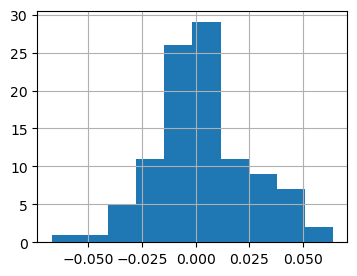

In [12]:
plt.figure(figsize = (4, 3))
df_corr_with_targ['corr_with_target'].hist()

#### Features selection

In [13]:
# ********* Gini of factors: *********

feature_columns = X_not_target.columns
print(len(feature_columns))

102


In [14]:
d_gini_by_feature = {}

for feature in feature_columns:

    # print(feature)
    
    min_value = X_not_target[feature].min()
    
    if min_value >= 0:
        auc = roc_auc_score(y, X_not_target[feature].fillna(-9999))
        
    else:
        idx = X_not_target[feature].notna()
        auc = roc_auc_score(y[idx], X_not_target[feature][idx])        
    
    max_auc = auc if auc > (1 - auc) else (1 - auc)
#   gini = 2 * max(auc, 1 - auc) - 1
    gini = 2 * max_auc - 1
    
    d_gini_by_feature[feature] = gini

# d_gini_by_feature
# ******************************************************************

gini_by_feature = pd.DataFrame(d_gini_by_feature, index = ['gini']).T

gini_by_feature = gini_by_feature.sort_values('gini', ascending = False)
gini_by_feature

,gini
revenue_detail_sum,0.449497
cust_segment_key_SH,0.406527
COUNT_EMPLOYEE,0.392460
STATEDCAPITAL,0.363682
OPF_общества,0.251861
...,...
REGION_TYPE_автономный округ,0.000189
REGION_TYPE_автономная область,0.000126
product_name_geoanalytics,0.000042
OKVED_CHAPTER_CODE_T,0.000007


<Axes: >

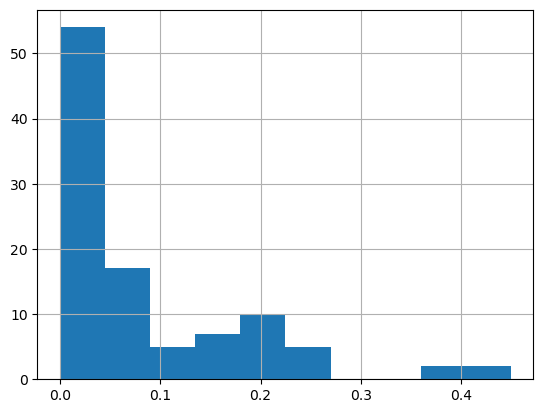

In [15]:
gini_by_feature['gini'].hist()

In [16]:
feature_columns = gini_by_feature.loc[(gini_by_feature['gini'] > 0.1)].index.tolist()
        
print('Оставляем {} фичей из {}'.format(len(feature_columns), gini_by_feature.shape[0]))
feature_columns

print(X_not_target.shape)
# X_not_target = X_not_target[feature_columns]
print(X_not_target.shape)

Оставляем 31 фичей из 102
(287733, 102)
(287733, 102)


In [17]:
feature_columns = gini_by_feature.loc[(gini_by_feature['gini'] > 0.05)].index.tolist()
        
print('Оставляем {} фичей из {}'.format(len(feature_columns), gini_by_feature.shape[0]))
feature_columns

print(X_not_target.shape)
X_not_target = X_not_target[feature_columns]
print(X_not_target.shape)

Оставляем 45 фичей из 102
(287733, 102)
(287733, 45)


#### Correlations

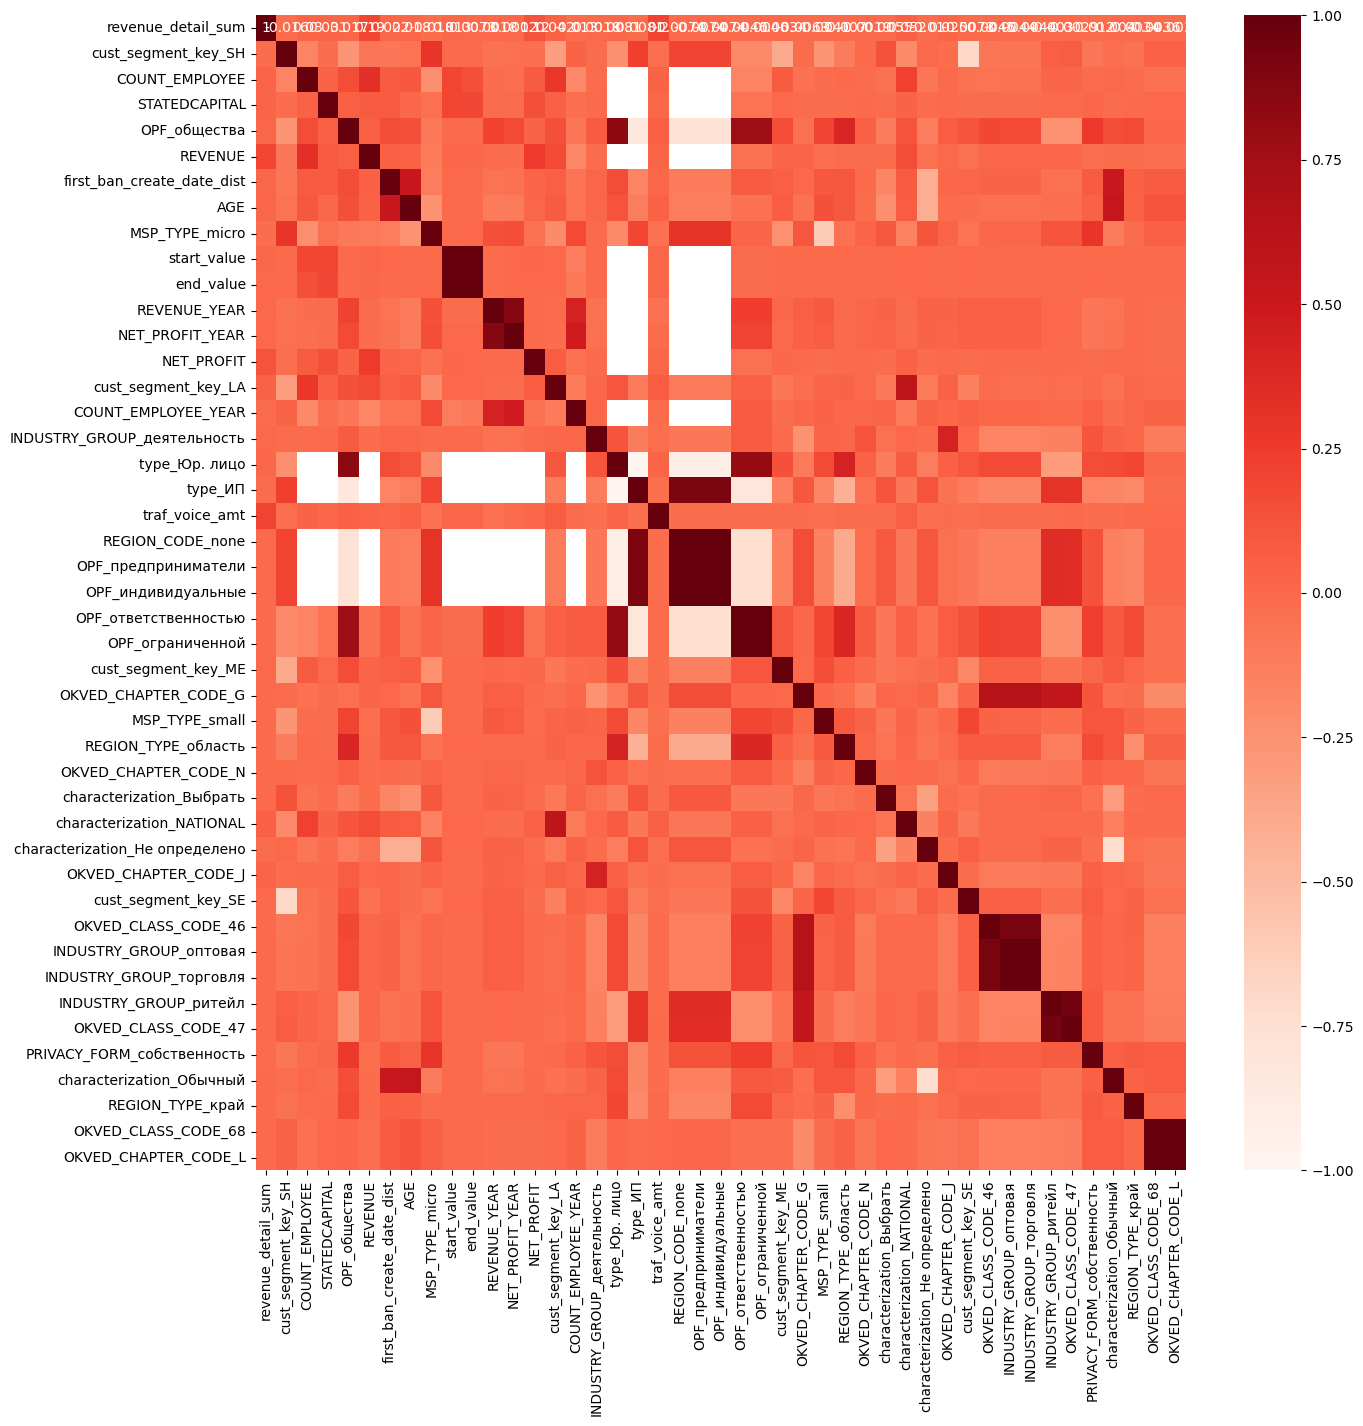

In [18]:
# Выведем матрицу корреляций и удалим зависиммые переменные:

plt.figure(figsize = (15, 15))

cor = X_not_target.corr()
sns.heatmap(cor, annot = True, cmap = plt.cm.Reds)
plt.show()

In [19]:
cnt = 0

for i in range(0, cor.shape[0]):
    for j in range(0, cor.shape[1]):
        
#         if (i > j) & (abs(cor.iloc[i,j]) > 0.9):
        if (i > j) & ( (cor.iloc[i,j] > 0.9) | (cor.iloc[i,j] < -0.9) ):
            cnt += 1
            print('corr(', cor.index[i], ',', cor.columns[j], ') = ', cor.iloc[i][j])
        
print(cnt) 

corr( end_value , start_value ) =  0.9997102322468211
corr( type_ИП , type_Юр. лицо ) =  -1.000000000000001
corr( REGION_CODE_none , type_Юр. лицо ) =  -0.9115250453672968
corr( REGION_CODE_none , type_ИП ) =  0.9115250453672941
corr( OPF_предприниматели , type_Юр. лицо ) =  -0.9070632163649293
corr( OPF_предприниматели , type_ИП ) =  0.9070632163649281
corr( OPF_предприниматели , REGION_CODE_none ) =  0.9951052442024035
corr( OPF_индивидуальные , type_Юр. лицо ) =  -0.9070632163649293
corr( OPF_индивидуальные , type_ИП ) =  0.9070632163649281
corr( OPF_индивидуальные , REGION_CODE_none ) =  0.9951052442024035
corr( OPF_индивидуальные , OPF_предприниматели ) =  1.0
corr( OPF_ограниченной , OPF_ответственностью ) =  1.0
corr( INDUSTRY_GROUP_оптовая , OKVED_CLASS_CODE_46 ) =  0.9319394056740721
corr( INDUSTRY_GROUP_торговля , OKVED_CLASS_CODE_46 ) =  0.9319394056740721
corr( INDUSTRY_GROUP_торговля , INDUSTRY_GROUP_оптовая ) =  1.0
corr( OKVED_CLASS_CODE_47 , INDUSTRY_GROUP_ритейл ) =  0

In [20]:
# + Удаление сильно коррелирующих признаков

THRESHOLD_FOR_CORRELATION = 0.9

feature_columns = list(X_not_target.columns)

# correlation_matrix = df[L1_columns].corr()
correlation_matrix = X_not_target.corr()

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > THRESHOLD_FOR_CORRELATION)]

feature_after_corr = [col for col in feature_columns if col not in to_drop]

print('По корреляции оставляем {} фичей из {}'.format( len(feature_after_corr), len(feature_columns) ))

По корреляции оставляем 36 фичей из 45


In [21]:
print(X_not_target.shape)
X_not_target = X_not_target[feature_after_corr]
print(X_not_target.shape)

(287733, 45)
(287733, 36)


In [22]:
cor = X_not_target.corr()
cnt = 0

for i in range(0, cor.shape[0]):
    for j in range(0, cor.shape[1]):
        
#         if (i > j) & (abs(cor.iloc[i,j]) > 0.9):
        if (i > j) & ( (cor.iloc[i,j] > 0.9) | (cor.iloc[i,j] < -0.9) ):
            cnt += 1
            print('corr(', cor.index[i], ',', cor.columns[j], ') = ', cor.iloc[i][j])
        
print(cnt) 

corr( type_ИП , type_Юр. лицо ) =  -1.000000000000001
1


In [23]:
temp_df = gini_by_feature.reset_index()
temp_df[(temp_df['index'] == 'type_ИП') | (temp_df['index'] == 'type_Юр. лицо')]

,index,gini
17,type_Юр. лицо,0.184037
18,type_ИП,0.184037


In [24]:
feature_after_corr = [i for i in feature_after_corr if i != 'type_Юр. лицо']
len(feature_after_corr)

35

In [25]:
X_not_target = X_not_target[feature_after_corr]
print(X_not_target.shape)

(287733, 35)


#### L1 regularization

In [26]:
cat_vars = X_not_target.select_dtypes(include  = [object]).columns
num_vars = X_not_target.select_dtypes(include = [np.number]).columns

X_not_target[cat_vars] = X_not_target[cat_vars].fillna('_miss',axis = 1)
X_not_target[num_vars] = X_not_target[num_vars].fillna(0, axis = 1)

In [27]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty = 'l1', solver = 'liblinear')

classifier.fit(X_not_target, y)

columns = X_not_target.columns

df_var_L1 = pd.concat([pd.DataFrame(columns).rename(columns = {0:'var'}), 
           pd.DataFrame(classifier.coef_).T.rename(columns = {0:'coef'})], axis = 1).sort_values(by = 'coef', ascending = False)
df_var_L1

# Выберем признаки с коэффицентами != 0:
df_L1 = df_var_L1[ df_var_L1['coef'] != 0 ]

print(df_L1.shape)
# df_L1.sort_values(by = 'coef', ascending = False)

features_L1 = list(df_L1['var'])
print(len(features_L1))
features_L1

(34, 2)
34


/home/ezagaynaya/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['OKVED_CHAPTER_CODE_N',
 'OPF_ответственностью',
 'OPF_общества',
 'OKVED_CHAPTER_CODE_J',
 'PRIVACY_FORM_собственность',
 'REGION_TYPE_край',
 'INDUSTRY_GROUP_деятельность',
 'OKVED_CHAPTER_CODE_G',
 'REGION_TYPE_область',
 'type_ИП',
 'MSP_TYPE_small',
 'AGE',
 'first_ban_create_date_dist',
 'COUNT_EMPLOYEE',
 'REVENUE_YEAR',
 'revenue_detail_sum',
 'STATEDCAPITAL',
 'REVENUE',
 'NET_PROFIT',
 'COUNT_EMPLOYEE_YEAR',
 'NET_PROFIT_YEAR',
 'traf_voice_amt',
 'MSP_TYPE_micro',
 'cust_segment_key_LA',
 'OKVED_CLASS_CODE_68',
 'characterization_NATIONAL',
 'INDUSTRY_GROUP_ритейл',
 'cust_segment_key_ME',
 'OKVED_CLASS_CODE_46',
 'characterization_Не определено',
 'characterization_Обычный',
 'cust_segment_key_SE',
 'characterization_Выбрать',
 'cust_segment_key_SH']

In [28]:
print(X_not_target.shape)
X_not_target = X_not_target[features_L1]
print(X_not_target.shape)

(287733, 35)
(287733, 34)


#### Backward Elimination

In [29]:
import statsmodels
import statsmodels.api as sm

def BE_func(var, y):
    
    cols = var
    pmax = 1
    
    while (len(cols) > 0):
        p = []
#         X_1 = df_BE[cols]
        X_1 = X_not_target[cols]
        
#       ****** Linear model: *******
        # X_1 = sm.add_constant(X_1)
        # model = sm.OLS(y.astype(float), X_1.astype(float)).fit()

#       *********** Classification model: *************
        model = sm.Logit(y, sm.add_constant(X_1)).fit()
        model = statsmodels.discrete.discrete_model.Logit(y, sm.add_constant(X_1)).fit()
        # print(model.summary())
        
        p = pd.Series(model.pvalues.values[1:], index = cols)      
        pmax = p.max()
        feature_with_p_max = p.idxmax()
        
        if(pmax > 0.05):
#         if(pmax > 0.1):
            # cols.remove(feature_with_p_max)
            cols = [i for i in cols if i not in feature_with_p_max]
        else:
            break
    selected_features_BE = cols
    
#     print(len(selected_features_BE))
#     print(list(selected_features_BE))
    return selected_features_BE

In [30]:
# Backward Elimination: 

columns = X_not_target.columns
# columns = features_L1                                          

selected_features_BE_all = BE_func(columns, y)

/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 17


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 11
Optimization terminated successfully.
         Current function value: inf
         Iterations 11


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


In [31]:
# selected_features_BE_all = ['OKVED_CHAPTER_CODE_D',
#  'OKVED_CHAPTER_CODE_N',
#  'cust_segment_key_KA',
#  'OPF_ответственностью',
#  'OPF_общества',
#  'OKVED_CHAPTER_CODE_J',
#  'cust_segment_key_LA',
#  'INDUSTRY_GROUP_деятельность',
#  'characterization_Заказчик 223-ФЗ',
#  'REGION_TYPE_край',
#  'OKVED_CHAPTER_CODE_G',
#  'cust_segment_key_ME',
#  'REGION_TYPE_область',
#  'characterization_NATIONAL',
#  'AGE',
#  'first_ban_create_date_dist',
#  'COUNT_EMPLOYEE',
#  'revenue_detail_sum',
#  'STATEDCAPITAL',
#  'traf_voice_amt',
#  'COUNT_EMPLOYEE_YEAR',
#  'MSP_TYPE_micro',
#  'OKVED_CHAPTER_CODE_L',
#  'INDUSTRY_GROUP_ритейл',
#  'characterization_Выбрать',
#  'INDUSTRY_GROUP_оптовая',
#  'cust_segment_key_SH']

# print(len(selected_features_BE_all))

In [32]:
print(len(selected_features_BE_all))
selected_features_BE_all

26


['OKVED_CHAPTER_CODE_N',
 'OPF_ответственностью',
 'OPF_общества',
 'OKVED_CHAPTER_CODE_J',
 'PRIVACY_FORM_собственность',
 'REGION_TYPE_край',
 'INDUSTRY_GROUP_деятельность',
 'OKVED_CHAPTER_CODE_G',
 'REGION_TYPE_область',
 'type_ИП',
 'AGE',
 'first_ban_create_date_dist',
 'COUNT_EMPLOYEE',
 'revenue_detail_sum',
 'COUNT_EMPLOYEE_YEAR',
 'MSP_TYPE_micro',
 'OKVED_CLASS_CODE_68',
 'characterization_NATIONAL',
 'INDUSTRY_GROUP_ритейл',
 'cust_segment_key_ME',
 'OKVED_CLASS_CODE_46',
 'characterization_Не определено',
 'characterization_Обычный',
 'cust_segment_key_SE',
 'characterization_Выбрать',
 'cust_segment_key_SH']

In [33]:
print(X_not_target.shape)
X_not_target = X_not_target[selected_features_BE_all]
print(X_not_target.shape)

(287733, 34)
(287733, 26)


In [66]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

features_list = selected_features_BE_all

X_not_target = X_not_target[features_list]
print(X_not_target.shape)

X_train, X_test, y_train, y_test = train_test_split(X_not_target, y, test_size = 0.2, random_state = 42, stratify = y)

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())

(287733, 26)
(230186, 26) (57547, 26)
0.006625077111553266 0.00662067527412376


#### Class weight

In [452]:
# clf_lgb = lgb.LGBMClassifier() 
# clf_lgb = lgb.LGBMClassifier(class_weight = 'balanced')     # cutoff 0.8:  0.10     0.55;   10 278
# clf_lgb = lgb.LGBMClassifier(class_weight = {0: 1, 1: 6})   # cutoff 0.2:  0.22     0.09     0.13     381;   0.2	 8 328
# cutoff = 0.2:   0.13   0.0257; 	8 328

clf_lgb = lgb.LGBMClassifier(class_weight = {0: 1, 1: 7})     # cutoff 0.2:  0.19     0.10     0.13     381 ;  0.2	 10 045
# cutoff = 0.2:   0.124  0.658; 	10 045

clf_lgb.fit(X_train, y_train)

print('\n')
y_pred_train = clf_lgb.predict_proba(X_train)[:,1]
AUC_train = metrics.roc_auc_score(y_train, y_pred_train)
Gini_train = 2 * AUC_train - 1
print('AUC_train:', AUC_train)
print('Gini_train:', Gini_train)

print()

y_pred_test = clf_lgb.predict_proba(X_test)[:,1]
AUC_test = metrics.roc_auc_score(y_test, y_pred_test)
Gini_test = 2 * AUC_test - 1
print('AUC_test:', AUC_test)
print('Gini_test:', Gini_test)

# class_weight = {0: 1, 1: 6}
# AUC_train: 0.9669264264853097
# Gini_train: 0.9338528529706194

# AUC_test: 0.8661790596855518
# Gini_test: 0.7323581193711035

# class_weight = {0: 1, 1: 7}
# AUC_train: 0.9673909956617718
# Gini_train: 0.9347819913235436

# AUC_test: 0.8649254237073355
# Gini_test: 0.729850847414671

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1525, number of negative: 228661
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 230186, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044603 -> initscore=-3.064336
[LightGBM] [Info] Start training from score -3.064336


AUC_train: 0.9673909956617718
Gini_train: 0.9347819913235436

AUC_test: 0.8649254237073355
Gini_test: 0.729850847414671


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


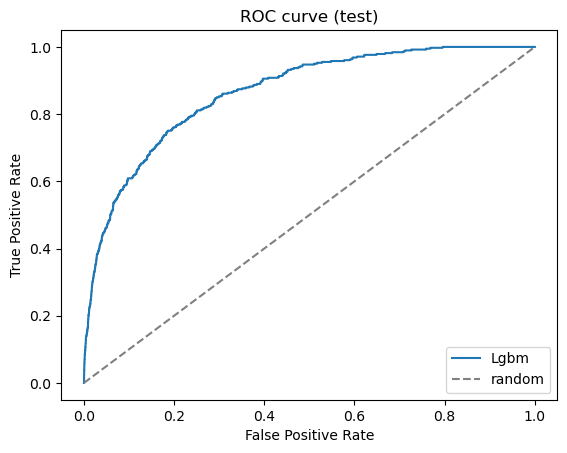

In [453]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test)

pylab.plot(fpr, tpr, label = 'Lgbm')
pylab.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve (test)')
pylab.legend(loc = "lower right")

In [454]:
X_not_target[features_list].shape

(287733, 26)

In [455]:
from sklearn import model_selection, datasets, linear_model, metrics

# kfold = model_selection.KFold(n_splits = 4)
skf = StratifiedKFold(n_splits = 4)

# AUC_cv = cross_val_score(clf_lgb, X_not_target[features_list], y, cv = kfold, scoring = 'roc_auc', n_jobs = -1)
AUC_cv = cross_val_score(clf_lgb, X_not_target[features_list], y, cv = skf, scoring = 'roc_auc', n_jobs = -1)
AUC_cv

# array([0.8809431 , 0.87812104, 0.88234937, 0.86785004])
# segments:
# array([0.86549316, 0.86213871, 0.8595668 , 0.85851961])

# balanced: 
# array([0.8718053 , 0.87672981, 0.86745318, 0.86241117])

# {0: 1, 1: 6}
# array([0.87070809, 0.87463958, 0.86815959, 0.86584511])

# {0: 1, 1: 7}
# array([0.8698145 , 0.87520374, 0.86859934, 0.86584995])

array([0.8698145 , 0.87520374, 0.86859934, 0.86584995])

In [456]:
# X_not_target[features_list], y

# df_major.groupby('cust_segment_key').sample(frac = 0.6)

In [457]:
# *****************************************************************************************************************

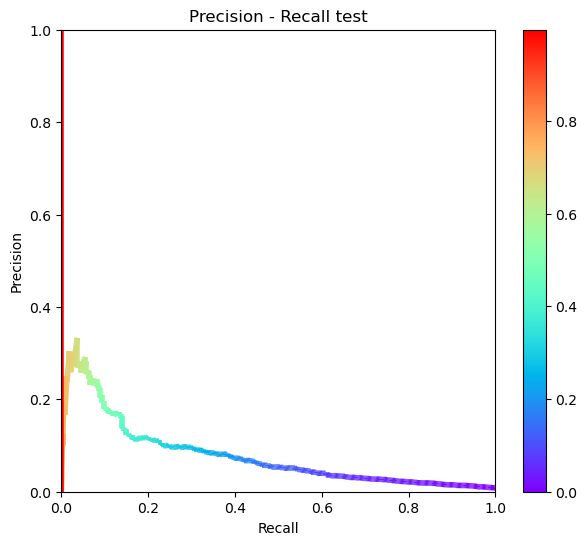

In [458]:
# Precision recall curve
from sklearn.metrics import precision_recall_curve

precision1, recall1, threshold1 = precision_recall_curve( y_test, y_pred_test )

from matplotlib.collections import LineCollection

x    = recall1
y_pr    = precision1
cols = threshold1

points = np.array([x, y_pr]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis = 1)

fig, ax = plt.subplots(figsize = (7, 6))
#lc = LineCollection(segments, cmap ='viridis')
lc = LineCollection(segments, cmap = plt.cm.rainbow)

lc.set_array(cols)
lc.set_linewidth(4)
line = ax.add_collection(lc)
fig.colorbar(line, ax = ax)

#plt.figure(figsize = [15,15])

plt.xlabel("Recall")
plt.ylabel("Precision")
pylab.title('Precision - Recall test')
plt.show()

In [459]:
y_pred_train_class = clf_lgb.predict(X_train)
AUC_train_class = metrics.roc_auc_score(y_train, y_pred_train_class)

Gini_train_class = 2 * AUC_train_class - 1
print('AUC_train_class:', AUC_train_class)
print('Gini_train_class:', Gini_train_class)

print()

y_pred_test_class = clf_lgb.predict(X_test)
AUC_test_class = metrics.roc_auc_score(y_test, y_pred_test_class)
Gini_test_class = 2 * AUC_test_class - 1
print('AUC_test_class:', AUC_test_class)
print('Gini_test_class:', Gini_test_class)

# AUC_train_class: 0.5776170694666405
# Gini_train_class: 0.15523413893328097

# AUC_test_class: 0.5448384513196041
# Gini_test_class: 0.08967690263920813

AUC_train_class: 0.592329493994295
Gini_train_class: 0.18465898798859004

AUC_test_class: 0.547183236589706
Gini_test_class: 0.09436647317941205


In [460]:
cm = metrics.confusion_matrix(y_test, y_pred_test_class)
print(cm)

TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
print('TP:', TP)
print('FP:', FP)

[[57009   157]
 [  344    37]]
TP: 37
FP: 157


In [461]:
metrics.accuracy_score(y_test, y_pred_test_class)

0.9912940726710341

In [462]:
print(metrics.classification_report(y_test, y_pred_test_class))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     57166
           1       0.19      0.10      0.13       381

    accuracy                           0.99     57547
   macro avg       0.59      0.55      0.56     57547
weighted avg       0.99      0.99      0.99     57547



In [463]:
y_pred_all = clf_lgb.predict_proba(X_not_target)[:,1]

p, r, thresholds = precision_recall_curve(y, y_pred_all)

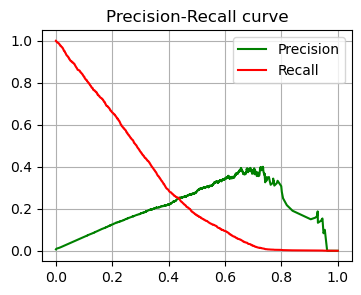

In [464]:
plt.figure(figsize = (4, 3))

plt.plot(thresholds, p[:-1], "g-", label = "Precision")
plt.plot(thresholds, r[:-1], "r-", label = "Recall")
plt.title('Precision-Recall curve')
plt.legend(loc = "upper right")
plt.grid()
plt.show()

In [465]:
y_pred_all_01 = pd.DataFrame(y_pred_all).rename(columns = {0: 'predict'})
y_pred_all_01 = y_pred_all_01['predict'].apply(lambda x: 1 if x >= 0.2 else 0)
# y_pred_all_01

In [466]:
confusion = metrics.confusion_matrix(y, y_pred_all_01)
confusion

array([[277037,   8790],
       [   651,   1255]])

In [467]:
# Precision:
# TP / TP + FP

Precision = confusion[1,1]/(confusion[0,1] + confusion[1,1])
Precision

# classic:
# cutoff = 0.2   0.4008583690987124
# cutoff = 0.4   0.47112462006079026
# cutoff = 0.5   0.42792792792792794
# cutoff = 0.8   0.29473684210526313

# class_weight = 'balanced' :
# cutoff = 0.2    0.03899882241566418
# cutoff = 0.8    0.1019653629110722

# class_weight = {0: 1, 1: 6}
# cutoff = 0.2   0.13808837656099904
# cutoff = 0.5   0.305159165751921
# cutoff = 0.7   0.4224137931034483
# cutoff = 0.8   0.2

# class_weight = {0: 1, 1: 7}
# cutoff = 0.2   0.1249377799900448
# cutoff = 0.5   0.2835820895522388
# cutoff = 0.7   0.38461538461538464
# cutoff = 0.8   0.28

0.1249377799900448

In [468]:
# Recall:
# TP / TP + FN

Recall = confusion[1,1]/(confusion[1,0] + confusion[1,1])
Recall
# cutoff = 0.2     0.9795383001049318
# cutoff = 0.8     0.5503672612801679

# class_weight = {0: 1, 1: 6}
# cutoff = 0.5    0.5503672612801679

0.6584470094438615

In [469]:
F = 2 * Precision * Recall / (Precision + Recall)
F
# class_weight = 'balanced':
# cutoff = 0.2     0.03451112322892502
# cutoff = 0.8     0.16077860372442332

# class_weight = {0: 1, 1: 6}
# cutoff = 0.5    0.3926228553618395

0.2100242657518199

In [498]:
import pickle

# ******************* save model 15.09: *******************

# with open('model_Lead_m2m_weighted.pkl', 'wb') as fid:

#         pickle.dump(clf_lgb, fid)

# ******************* read: ********************

with open('model_Lead_m2m_weighted.pkl', 'rb') as fid:
    
    clf_lgb_saved = pickle.load(fid)

In [499]:
y_pred_train = clf_lgb_saved.predict_proba(X_train)[:,1]
AUC_train = metrics.roc_auc_score(y_train, y_pred_train)

Gini_train = 2 * AUC_train - 1
print('AUC_train:', AUC_train)
print('Gini_train:', Gini_train)

print()

y_pred_test = clf_lgb_saved.predict_proba(X_test)[:,1]
AUC_test = metrics.roc_auc_score(y_test, y_pred_test)
Gini_test = 2 * AUC_test - 1
print('AUC_test:', AUC_test)
print('Gini_test:', Gini_test)

# AUC_train: 0.9673909956617718
# Gini_train: 0.9347819913235436

# AUC_test: 0.8649254237073355
# Gini_test: 0.729850847414671

AUC_train: 0.9673909956617718
Gini_train: 0.9347819913235436

AUC_test: 0.8649254237073355
Gini_test: 0.729850847414671


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


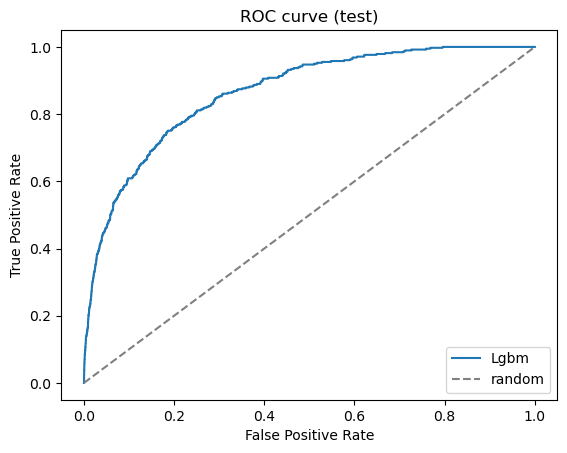

In [486]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test)

pylab.plot(fpr, tpr, label = 'Lgbm')
pylab.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve (test)')
pylab.legend(loc = "lower right")

In [489]:
y_pred_all = clf_lgb_saved.predict_proba(X_not_target)[:,1]
AUC_all = metrics.roc_auc_score(y, y_pred_all)

Gini_all = 2 * AUC_all - 1
print('AUC_all:', AUC_all)
print('Gini_all:', Gini_all)

# AUC_all: 0.9469727560787867
# Gini_all: 0.8939455121575735

AUC_all: 0.9469727560787867
Gini_all: 0.8939455121575735


In [490]:
# clf_lgb.get_params()

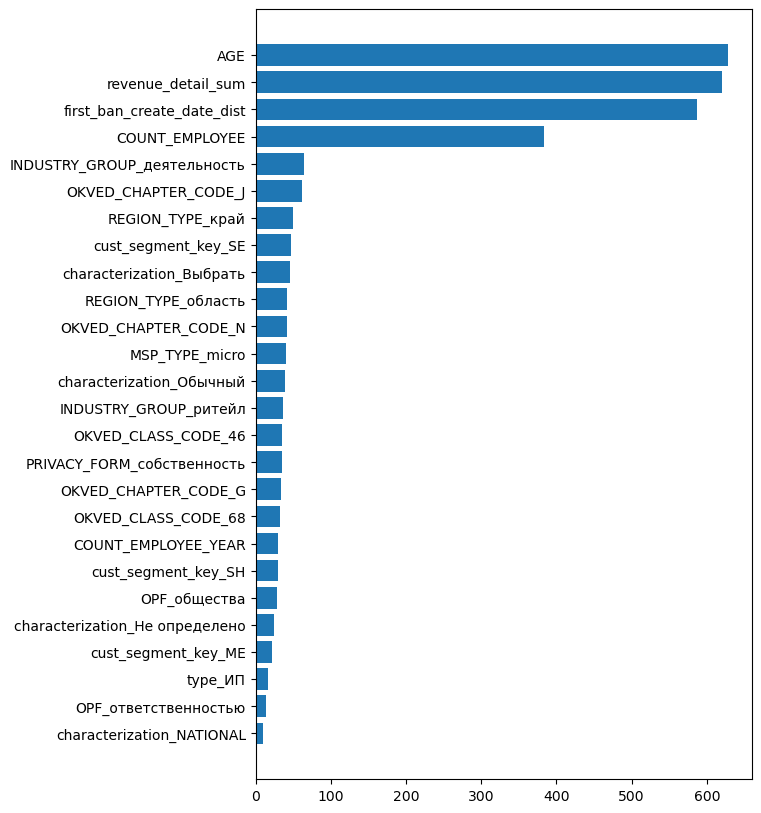

In [491]:
importances = clf_lgb.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots()

ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))

_ = ax.set_yticklabels(np.array(X_not_target.columns)[indices])

fig.set_figheight(10)

In [492]:
variable_importance = pd.DataFrame(sorted(zip(clf_lgb.feature_importances_, feature_columns), reverse=True))
variable_importance.columns = ['gain', 'feature']

variable_importance['gain_share'] = variable_importance['gain'] / variable_importance['gain'].sum()

variable_importance = variable_importance[['feature', 'gain', 'gain_share']]

variable_importance

,feature,gain,gain_share
0,end_value,628,0.209333
1,NET_PROFIT,620,0.206667
2,REVENUE_YEAR,587,0.195667
3,NET_PROFIT_YEAR,383,0.127667
4,first_ban_create_date_dist,65,0.021667
5,STATEDCAPITAL,62,0.020667
6,REVENUE,50,0.016667
7,OPF_ответственностью,47,0.015667
8,OPF_ограниченной,46,0.015333
9,revenue_detail_sum,42,0.014000


In [493]:
y_pred_all_df = pd.DataFrame(y_pred_all)
y_pred_all_df.rename(columns = {0: 'predict'}, inplace = True)
y_pred_all_df.head()

,predict
0,0.013876
1,0.000662
2,0.096072
3,0.080048
4,0.009979


In [494]:
def dependency_volume_threshold(y_pred_all):

    list_thresholds, list_number = [], []
    
    # for th_i in range(0, 10):
    for th_i in range(1, 10):

        th_i = th_i / 10

        y_pred_all_01_i = y_pred_all['predict'].apply(lambda x: 1 if x >= th_i else 0)
        
        confusion_i = metrics.confusion_matrix(y, y_pred_all_01_i)

        TP_i, FP_i, TN_i, FN_i = confusion_i[1,1], confusion_i[0,1], confusion_i[0,0], confusion_i[1,0]
        number_i = TP_i + FP_i
        list_thresholds.append(th_i)
        list_number.append(number_i)

    d = {'thresholds': list_thresholds, 'number': list_number}
    df_th_num = pd.DataFrame(d)

    return df_th_num
        
df_th_num = dependency_volume_threshold(y_pred_all_df)
df_th_num

,thresholds,number
0,0.1,23783
1,0.2,10045
2,0.3,5075
3,0.4,2480
4,0.5,1139
5,0.6,522
6,0.7,117
7,0.8,25
8,0.9,20


In [495]:
y.sum()

1906

Text(0.5, 0, 'threshold')

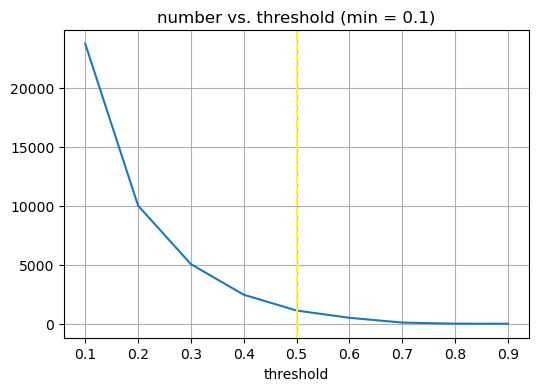

In [496]:
# df_th_num.plot()

plt.figure(figsize = (6, 4))

plt.plot(df_th_num['thresholds'], df_th_num['number'])
plt.axvline(x = 0.5, color = 'yellow', linestyle = '--')

plt.grid()
plt.title('number vs. threshold (min = 0.1)')
plt.xlabel("threshold")

Text(0.5, 0, 'threshold')

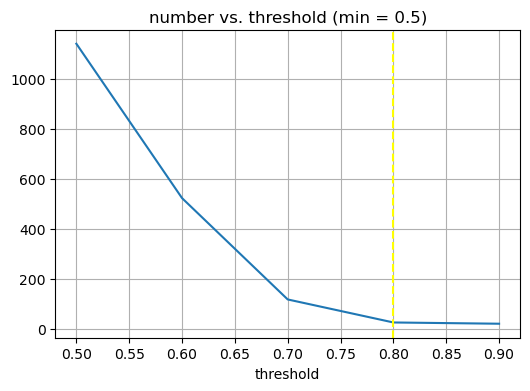

In [497]:
plt.figure(figsize = (6, 4))

plt.plot(df_th_num[df_th_num['thresholds'] >= 0.5]['thresholds'], 
         df_th_num[df_th_num['thresholds'] >= 0.5]['number'])

plt.axvline(x = 0.8, color = 'yellow', linestyle = '--')

plt.grid()
plt.title('number vs. threshold (min = 0.5)')
plt.xlabel("threshold")

In [482]:
# ********************************************************************************************************************************************

#### Hyperopt and k-fold CV for hyperparameters tuning

In [508]:
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    
    'n_estimators': 100,
    'learning_rate': 0.01, 
    
#     'feature_fraction': 0.75,
#     'bagging_fraction': 0.75,
#     'bagging_freq': 1,
    
    'min_gain_to_split': 1e-3,
    'reg_lambda': 1e-1,
   
#     'max_depth': 8,
    'num_leaves': 2**5,
    'min_data_in_leaf': 2**5, 
    
    'is_unbalance': True,
    'importance_type': 'gain',
    
    'nthread': -1,
    'bagging_seed': 42, 
}

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1429, number of negative: 214371
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 215800, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013157 -> initscore=-4.317586
[LightGBM] [Info] Start training from score -4.317586
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1430, number of negative: 214370
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

In [366]:
from hyperopt import fmin, tpe, hp

alpha = 0.5

space = {
    'n_estimators': hp.choice('n_estimators', list(range(30, 500, 10))),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.5)), 
    'max_depth': hp.quniform('max_depth', 3, 10, 1), 
    'colsample_bytree': hp.quniform('colsample_bytree', 0.8, 1, 0.01), 
    'min_child_samples': hp.quniform('min_child_samples', 2, 300, 1), 
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 5),
}

def objective(params):
    
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'importance_type': 'gain',

        'nthread': -1,
        'bagging_seed': 42, 
        
        'n_estimators': 100,
        'learning_rate': (params['learning_rate']),
        'num_leaves': 2**int(params['max_depth']),
        'max_depth': int(params['max_depth']),
        'colsample_bytree': (params['colsample_bytree']),
        'min_child_samples': int(params['min_child_samples']) ,
        'reg_lambda': params['reg_lambda'],
        'reg_alpha': params['reg_alpha'],
    }
 
    model_lgb = lgb.LGBMClassifier(**lgb_params)

    model_lgb.fit(
        X_train,
        y_train, 
        eval_metric = "auc",
        # verbose = -1,
        # early_stopping_rounds = 10,
        eval_set = [(X_train, y_train), (X_test, y_test)]
    )
 
    forecast_lgb_test = model_lgb.predict_proba(X_test)[:,1]
    score_test = roc_auc_score(y_test, forecast_lgb_test)
    
    if alpha > 0:
        forecast_lgb_train = model_lgb.predict_proba(X_train)[:,1]
        score_train = roc_auc_score(y_train, forecast_lgb_train)
        
        score_total = score_test - alpha * (score_train - score_test)
        
    else:
        score_total = score_test
    
    print("score {:.5f}; params {}".format(score_test, params))
    return -score_total

best = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 50
)

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
[LightGBM] [Info] Number of positive: 1894, number of negative: 240539
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1517                     
[LightGBM] [Info] Number of data points in the train set: 242433,

In [367]:
best

{'colsample_bytree': 0.93,
 'learning_rate': 0.10366005116679088,
 'max_depth': 7.0,
 'min_child_samples': 98.0,
 'n_estimators': 12,
 'reg_alpha': 4.396672045765595,
 'reg_lambda': 2.0620178916994973}

In [ ]:
# best =

# {'colsample_bytree': 0.93,
#  'learning_rate': 0.10366005116679088,
#  'max_depth': 7.0,
#  'min_child_samples': 98.0,
#  'n_estimators': 12,
#  'reg_alpha': 4.396672045765595,
#  'reg_lambda': 2.0620178916994973}

In [368]:
clf_lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [369]:
clf_lgb_best = lgb.LGBMClassifier(**best)
clf_lgb_best

LGBMClassifier(colsample_bytree=0.93, learning_rate=0.10366005116679088,
               max_depth=7.0, min_child_samples=98.0, n_estimators=12,
               reg_alpha=4.396672045765595, reg_lambda=2.0620178916994973)

In [372]:
clf_lgb_best = lgb.LGBMClassifier(colsample_bytree=0.93, learning_rate=0.10366005116679088,
               max_depth=7, min_child_samples=98, n_estimators=12,
               reg_alpha=4.396672045765595, reg_lambda=2.0620178916994973)

clf_lgb_best.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1894, number of negative: 240539
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 242433, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007812 -> initscore=-4.844191
[LightGBM] [Info] Start training from score -4.844191


LGBMClassifier(colsample_bytree=0.93, learning_rate=0.10366005116679088,
               max_depth=7, min_child_samples=98, n_estimators=12,
               reg_alpha=4.396672045765595, reg_lambda=2.0620178916994973)

In [373]:
X_not_target.shape

(303042, 27)

In [374]:
kfold = model_selection.KFold(n_splits = 4)

AUC_cv_best = cross_val_score(clf_lgb_best , X_not_target, y, cv = kfold, scoring = 'roc_auc', n_jobs = -1)
AUC_cv_best

# array([0.8809431 , 0.87812104, 0.88234937, 0.86785004])

array([0.8778184 , 0.88065136, 0.88315186, 0.86702695])

In [375]:
y_pred_test = clf_lgb_best.predict_proba(X_test)[:,1]
AUC_test = metrics.roc_auc_score(y_test, y_pred_test)
Gini_test = 2 * AUC_test - 1
print('AUC_test:', AUC_test)
print('Gini_test:', Gini_test)

# AUC_train: 0.9529361720384457
# Gini_train: 0.9058723440768914

# AUC_test: 0.879310824288062
# Gini_test: 0.7586216485761239

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC_test: 0.8783178670981434
Gini_test: 0.7566357341962868


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['fmin', 'cm', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


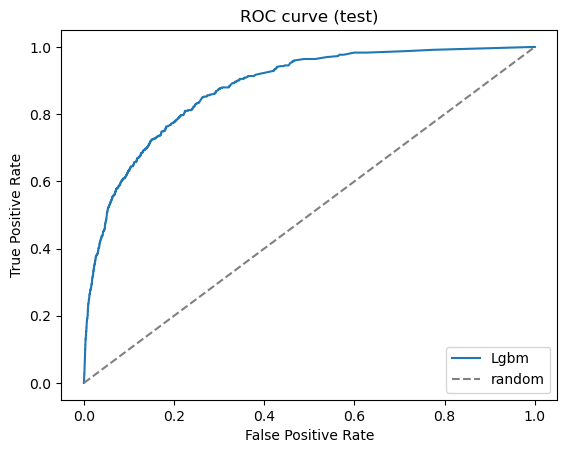

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1755, number of negative: 225526
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1515
[LightGBM] [Info] Number of data points in the train set: 227281, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007722 -> initscore=-4.855967
[LightGBM] [Info] Start training from score -4.855967
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth

In [376]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test)

pylab.plot(fpr, tpr, label = 'Lgbm')
pylab.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve (test)')
pylab.legend(loc = "lower right")

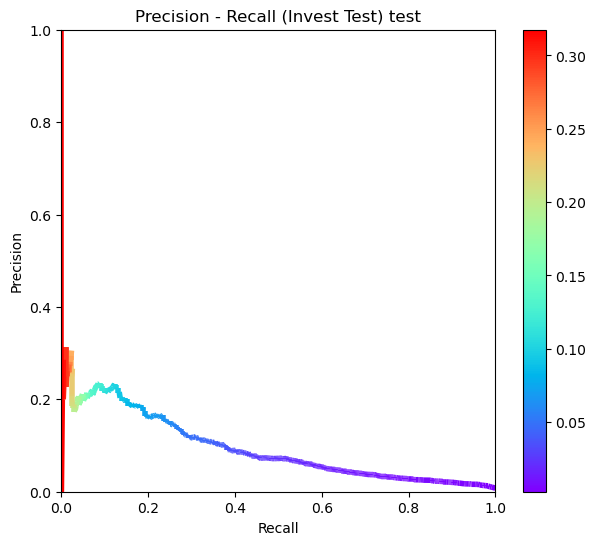

In [377]:
# Precision recall curve
from sklearn.metrics import precision_recall_curve

precision1, recall1, threshold1 = precision_recall_curve( y_test, y_pred_test )

from matplotlib.collections import LineCollection

x    = recall1
y_pr    = precision1
cols = threshold1

points = np.array([x, y_pr]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis = 1)

fig, ax = plt.subplots(figsize = (7, 6))
#lc = LineCollection(segments, cmap ='viridis')
lc = LineCollection(segments, cmap = plt.cm.rainbow)

lc.set_array(cols)
lc.set_linewidth(4)
line = ax.add_collection(lc)
fig.colorbar(line, ax = ax)

#plt.figure(figsize = [15,15])

plt.xlabel("Recall")
plt.ylabel("Precision")
pylab.title('Precision - Recall test')
plt.show()

In [378]:
y_pred_train_class = clf_lgb.predict(X_train)
AUC_train_class = metrics.roc_auc_score(y_train, y_pred_train_class)

Gini_train_class = 2 * AUC_train_class - 1
print('AUC_train_class:', AUC_train_class)
print('Gini_train_class:', Gini_train_class)

print()

y_pred_test_class = clf_lgb_best.predict(X_test)
AUC_test_class = metrics.roc_auc_score(y_test, y_pred_test_class)
Gini_test_class = 2 * AUC_test_class - 1
print('AUC_test_class:', AUC_test_class)
print('Gini_test_class:', Gini_test_class)

# AUC_train_class: 0.5348905379621453
# Gini_train_class: 0.0697810759242905

# AUC_test_class: 0.5225989694676563
# Gini_test_class: 0.04519793893531254

AUC_train_class: 0.5348905379621453
Gini_train_class: 0.0697810759242905

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC_test_class: 0.5
Gini_test_class: 0.0


In [379]:
# ******************************************************************************************************************

In [381]:
fa = spark.table('b2bba_dm.fa_revenue_detail')

sdf = (fa.filter(
    (col('dt') >= '2024-10-01') &
    (col('dt') <=  '2025-07-01') &
    (col('revenue_type') == 'mobile_vdm') &
    (col('flag_mk') == 0) &
    (col('flag_sp') == 0) &
    (col('subsegment').isin('LA', 'ME', 'SE', 'SH')) &
    (col('flag_otm') == 0)
    
))

In [385]:
sdf.describe

<bound method DataFrame.describe of DataFrame[dt: timestamp, contract_no: string, inn: string, client_id: string, client_name: string, client_group_id: string, client_group_name: string, region: string, mkt: string, market: string, segment: string, subsegment: string, flag_agent: int, flag_mk: int, flag_gos: int, flag_national: string, flag_alloc: int, flag_sp: int, flag_otm: int, sales: string, sales_tn: string, sales_func: string, revenue_type: string, account: string, domain: string, revenue: decimal(38,2), source_name: string, load_date: timestamp]>

#### Spark download

In [382]:
from pyspark.sql.types import StringType, FloatType, LongType, ByteType, ArrayType, StructType, StructField, IntegerType, DateType

In [ ]:
# # спарк датафрейм создавать, например, вот так:

# mySchema = StructType(
#     [
#         StructField("CLIENT_INN", StringType(), True)
#         ,StructField("y_pred_proba_samp", FloatType(), True)
#     ]
# )
                   
# X_out_sdf = spark.createDataFrame(X_out, schema = mySchema)

In [386]:
resulting_table ='b2b_cltv_stg.fa_revenue_detail_2708'

db_name, table_name = resulting_table.split(".")
   
(
    sdf
    .repartition(10)
    .write.mode("overwrite")
    .format("parquet")
    .option("path", f"hdfs://ns-etl/warehouse/tablespace/external/hive/{db_name}.db/{table_name}")
    #.partitionBy("transaction_dt")
    .saveAsTable(resulting_table)
)

# где res_sdf - это твой спарк-датафрейм
# resulting_table ='b2b_cltv_stg.your_table_name'

In [388]:
fa_2 = spark.table('b2b_cltv_stg.fa_revenue_detail_2708')

print(fa_2.count())
fa_2.show(3)

2028254


+-------------------+-----------+------------+----------+--------------------+---------------+-----------------+------+---+-------------------+-------+----------+----------+-------+--------+-------------+----------+-------+--------+--------------------+--------+--------------+------------+--------------------+------+-------+--------------------+--------------------+
|                 dt|contract_no|         inn| client_id|         client_name|client_group_id|client_group_name|region|mkt|             market|segment|subsegment|flag_agent|flag_mk|flag_gos|flag_national|flag_alloc|flag_sp|flag_otm|               sales|sales_tn|    sales_func|revenue_type|             account|domain|revenue|         source_name|           load_date|
+-------------------+-----------+------------+----------+--------------------+---------------+-----------------+------+---+-------------------+-------+----------+----------+-------+--------+-------------+----------+-------+--------+--------------------+--------+